# Neonatal Incubator Display Reader

This notebook demonstrates the complete **end-to-end workflow** for developing an automated system to detect and extract vital sign readings from neonatal incubator displays. 



![manualimage](../screenshots/manualwrittennotes.png)


incubator LCD display

![lcdDisplay](../dataset/01518abf-WhatsApp_Image_2025-08-17_at_9.07.33_PM_1.jpeg)

The pipeline includes:

- **Object detection** using YOLOv8 to locate display regions
- **Optical Character Recognition (OCR)** to extract numeric readings
- **Post-processing validation** to ensure medical accuracy
- **Performance evaluation** metrics and visualization
- **Model export** for production deployment


## Pipeline Roadmap

The development workflow consists of the following stages:

1. **Environment Setup** - Install required dependencies and configure the development environment
2. **Dataset Exploration** - Analyze image characteristics, resolutions, and lighting conditions
3. **Annotation Workflow** - Label bounding boxes using Label Studio
4. **YOLO Data Preparation** - Convert annotations to YOLO format and split datasets
5. **Model Training** - Train YOLOv8 detector on annotated data
6. **Model Evaluation** - Assess detection performance using standard metrics
7. **Detection Inference** - Validate detector outputs on test images
8. **OCR Integration** - Extract numeric values using EasyOCR
9. **Performance Validation** - Measure combined detection and OCR accuracy
10. **Data Persistence** - Export structured readings for downstream applications
11. **Production Deployment** - Integrate with Streamlit dashboard for real-time monitoring


## Environment Setup and Dependency Installation

This cell installs all required Python packages for the pipeline:

- **NumPy and SciPy** - Numerical computing libraries with specific versions for compatibility
- **EasyOCR** - Optical Character Recognition library for text extraction
- **Ultralytics** - YOLOv8 implementation for object detection
- **Protobuf and TensorBoard** - Dependencies for model training visualization and logging

**Note:** Run this cell only once per kernel session. The `--quiet` flag suppresses verbose installation output.


In [16]:
# Environment setup (run once per kernel)
%pip install --user --quiet "numpy<2" "scipy==1.11.4"
%pip install --user --quiet easyocr==1.7.1 ultralytics==8.1.0
# Fix TensorBoard compatibility issues
%pip install --user --quiet --upgrade protobuf==3.20.3
%pip install --user --quiet tensorboard==2.14.0

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Library Imports and Project Configuration

This cell performs critical initialization tasks:

### Library Imports

- **Core Libraries** - Path, JSON, random, shutil for file operations
- **Scientific Computing** - NumPy, Pandas, Matplotlib for data processing and visualization
- **Computer Vision** - OpenCV (cv2) for image processing
- **Deep Learning** - PyTorch and Ultralytics YOLO for model training

### Environment Configuration

- **Warning Suppression** - Disables TensorFlow and deprecation warnings for cleaner output
- **PyTorch Configuration** - Patches torch.load for compatibility with YOLO models

### Project Structure Setup

- **Directory Resolution** - Automatically locates project root directory
- **Path Configuration** - Defines all working directories (dataset, artifacts, models)
- **Directory Creation** - Creates necessary folders if they don't exist

### Class Definitions

- **CLASS_NAMES** - Defines the four vital sign parameters to detect
- **CLASS_MAP** - Maps class names to numeric indices for YOLO training
- **ID_TO_CLASS_NAME** - Reverse mapping for prediction decoding


In [ ]:
from pathlib import Path
import json
import random
import shutil
import warnings
import os
import torch
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Suppress TensorFlow/TensorBoard warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)



# Import YOLO with error handling for TensorBoard issues
try:
    from ultralytics import YOLO
except ImportError as e:
    print(f"Warning: {e}")
    print("Installing missing dependencies...")
    import subprocess
    subprocess.run(["pip", "install", "--upgrade", "protobuf==3.20.3"], check=False)
    subprocess.run(["pip", "install", "--upgrade", "tensorboard==2.14.0"], check=False)
    from ultralytics import YOLO

from torch.serialization import add_safe_globals
from ultralytics.nn.tasks import DetectionModel
from ultralytics.nn import modules as yolo_modules
from ultralytics.nn.modules import Conv
from torch.nn import modules as torch_nn_modules

# Store original torch.load before any modifications
if not hasattr(torch, '_original_load_saved'):
    torch._original_load_saved = torch.load
    torch._no_nep50_warning = lambda: lambda func: func

def _safe_torch_load(*args, **kwargs):
    kwargs.setdefault("weights_only", False)
    return torch._original_load_saved(*args, **kwargs)

torch.load = _safe_torch_load

allowed_globals = {DetectionModel, Conv}
allowed_globals.update({obj for obj in vars(yolo_modules).values() if isinstance(obj, type)})
allowed_globals.update({obj for obj in vars(torch_nn_modules).values() if isinstance(obj, type)})
add_safe_globals(list(allowed_globals))

if not hasattr(np, "_no_nep50_warning"):
    def _no_nep50_warning():
        def decorator(func):
            return func
        return decorator
    np._no_nep50_warning = _no_nep50_warning


def resolve_project_root() -> Path:
    cwd = Path.cwd()
    if (cwd / "dataset").exists():
        return cwd
    if (cwd.parent / "dataset").exists():
        return cwd.parent
    return cwd

PROJECT_DIR = resolve_project_root()
DATASET_DIR = PROJECT_DIR / "dataset"
WORK_DIR = PROJECT_DIR / 'artifacts'
LABELS_DIR = WORK_DIR / 'labels'
IMAGES_DIR = WORK_DIR / 'images'
YOLO_DATA_DIR = WORK_DIR / 'yolo'
MODEL_DIR = PROJECT_DIR / 'models'
WORK_DIR.mkdir(exist_ok=True)
LABELS_DIR.mkdir(exist_ok=True)
IMAGES_DIR.mkdir(exist_ok=True)
YOLO_DATA_DIR.mkdir(exist_ok=True)
MODEL_DIR.mkdir(exist_ok=True)

CLASS_NAMES = [
     'heart_rate_value',
     'humidity_value',
     'skin_temp_value',
     'spo2_value',
]
CLASS_MAP = {name: idx for idx, name in enumerate(CLASS_NAMES)}
ID_TO_CLASS_NAME = {idx: name for name, idx in CLASS_MAP.items()}
CLASS_MAP

{'heart_rate_value': 0,
 'humidity_value': 1,
 'skin_temp_value': 2,
 'spo2_value': 3}

### Load Dataset Images

This cell discovers and collects all image files from the dataset directory:

**Process:**

1. Searches for images with common extensions (jpg, jpeg, png - both lowercase and uppercase)
2. Uses glob patterns to find all matching files
3. Resolves paths to absolute paths and removes duplicates
4. Sorts the paths for consistent ordering

**Output:** Returns the total count of discovered images for verification.


In [2]:
image_paths = []
if DATASET_DIR.exists():
    for pattern in ("*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"):
        image_paths.extend(DATASET_DIR.glob(pattern))
image_paths = sorted({path.resolve() for path in image_paths})
len(image_paths)

259

### Visualize Random Image Samples

This cell creates a **visual grid** displaying random samples from the dataset:

**Function:** `plot_samples()`

- Randomly selects images from the dataset
- Arranges them in a grid layout (default: 3 columns)
- Converts images from BGR to RGB color space for proper display
- Displays image filenames as titles

**Purpose:** Provides a quick visual overview of dataset characteristics, lighting conditions, and image quality.


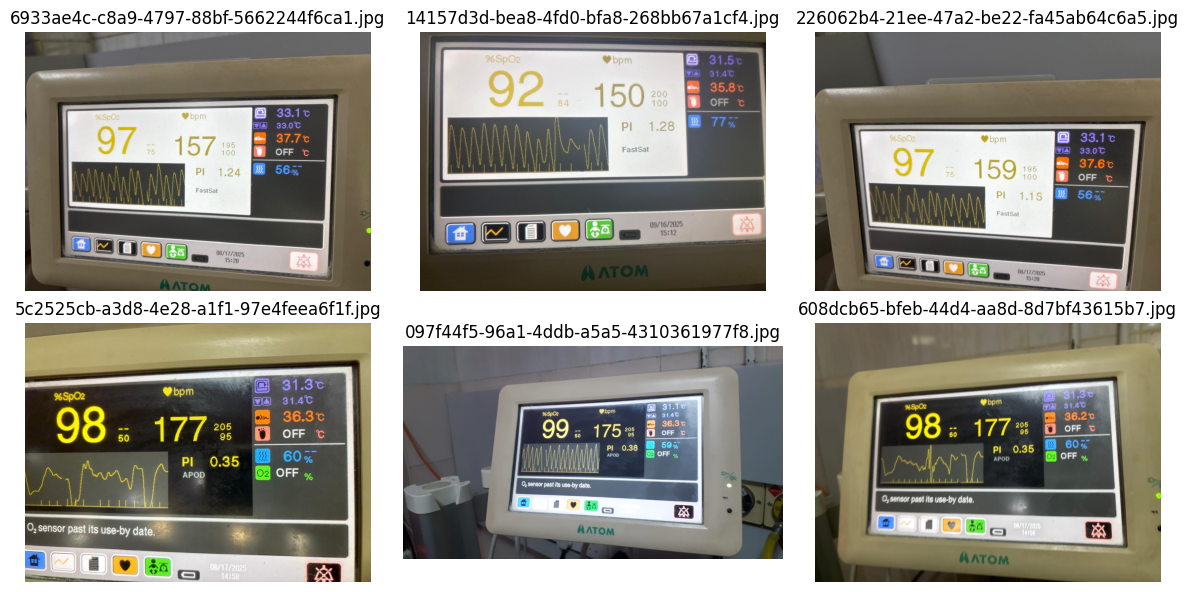

In [3]:
def plot_samples(paths, n=6, cols=3):
    sample_paths = random.sample(paths, min(n, len(paths)))
    rows = int(np.ceil(len(sample_paths) / cols))
    plt.figure(figsize=(4 * cols, 3 * rows))
    for idx, path in enumerate(sample_paths, 1):
        img = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, idx)
        plt.imshow(img)
        plt.title(path.name)
        plt.axis('off')
    plt.tight_layout()

plot_samples(image_paths)

### Dataset Exploration

This section performs **exploratory data analysis** on the input images to understand:

- **Image resolutions** and dimensions
- **Brightness distribution** across different lighting conditions
- **Visual characteristics** of dark and light display themes

**Key Observation:** The dataset contains displays with varying lighting conditions. **Grayscale conversion** and **histogram equalization** will be applied during OCR preprocessing to standardize input and improve text recognition accuracy.


### Brightness Analysis

This cell analyzes the **brightness distribution** across the entire dataset:

**Function:** `compute_brightness()`

- Converts each image to grayscale
- Calculates mean pixel intensity (0-255 scale)
- Lower values indicate darker images, higher values indicate brighter images

**Output:** Statistical summary showing minimum, maximum, mean, and standard deviation of brightness values across all images.

**Application:** Helps determine if preprocessing steps like histogram equalization are necessary to handle varying lighting conditions.



In [4]:
def compute_brightness(path):
    gray = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2GRAY)
    return gray.mean()

brightness = pd.Series({p.name: compute_brightness(p) for p in image_paths})
brightness.describe()

count    259.000000
mean     115.123825
std       16.008092
min       43.631552
25%      114.498931
50%      118.037595
75%      121.505554
max      148.440418
dtype: float64

## Annotation Workflow with Label Studio

**Objective:** Create bounding box annotations for each vital sign region in the incubator display.

**Tool:** Label Studio - an open-source data labeling platform

**Setup Instructions:**

1. Install Label Studio (one-time setup):

   ```bash
   pip install label-studio
   label-studio start --port 8080
   ```

2. Create a new project named "Incubator Display Detection"

3. Import images from the `dataset/` directory

4. Configure the labeling interface with **bounding box** tool for the following classes:

   - heart_rate_value
   - humidity_value
   - skin_temp_value
   - spo2_value

5. Annotate all images (recommended: start with 100 images, then iterate)

6. Export annotations in **YOLO format**

**Best Practice:** Maintain consistent annotation quality by having multiple annotators review critical samples and resolve discrepancies.


![Labelling](../screenshots/Screenshot01.png)


## Train/Validation/Test Split

After completing the annotation process, the dataset must be divided into three subsets:

- **Training Set (70%)** - Used to train the model
- **Validation Set (20%)** - Used for hyperparameter tuning and model selection
- **Test Set (10%)** - Used for final performance evaluation

The split is performed in **YOLO format**, maintaining matching image-label pairs across all subsets.


**Important Note:** The following cells require **completed annotations** in YOLO format.

**Prerequisites:**

- Bounding box annotations completed in Label Studio
- Annotations exported in YOLO format
- `YOLO_DATA_DIR` contains both `images/` and `labels/` subdirectories with matching files

**Action Required:** If annotations are not yet complete, return to the Label Studio workflow section. Once the directory structure is ready, uncomment the example function calls (lines starting with `#`) to execute the split, training, and evaluation steps.


### Dataset Splitting Function

This cell defines the `split_dataset()` function to divide annotated data into train/validation/test sets:

**Key Features:**

- **Proportional Split** - Default: 70% train, 20% validation, 10% test
- **Pair Validation** - Ensures each image has a corresponding label file
- **Random Shuffling** - Uses seed for reproducible splits
- **Error Handling** - Reports missing labels and validates directory structure

**Process:**

1. Locates all image files in the images directory
2. Finds matching label files in the labels directory
3. Randomly shuffles valid image-label pairs
4. Splits pairs according to specified proportions
5. Copies files to separate train/val/test subdirectories

**Output:** Returns the split root directory path and prints split statistics.




In [6]:
import math
import yaml
import random
import shutil
from collections import defaultdict

def split_dataset(yolo_dir, train=0.7, val=0.2, test=0.1, seed=42):
    """
    Split dataset into train, validation, and test sets.

    Args:
        yolo_dir: Path to directory containing 'images' and 'labels' subdirectories
        train: Proportion for training set (default: 0.7)
        val: Proportion for validation set (default: 0.2)
        test: Proportion for test set (default: 0.1)
        seed: Random seed for reproducibility (default: 42)
    """
    assert math.isclose(train + val + test, 1.0, rel_tol=1e-6)

    yolo_dir = Path(yolo_dir)
    images_dir = yolo_dir / 'images'
    labels_dir = yolo_dir / 'labels'

    if not images_dir.exists():
        raise FileNotFoundError(f"Images directory not found: {images_dir}")
    if not labels_dir.exists():
        raise FileNotFoundError(f"Labels directory not found: {labels_dir}")

    image_files = []
    for ext in ('.jpg', '.jpeg', '.png', '.bmp', '.JPG', '.JPEG', '.PNG'):
        image_files.extend(images_dir.glob(f'*{ext}'))

    if not image_files:
        raise FileNotFoundError(f"No image files found in {images_dir}")

    valid_pairs = []
    missing_labels = []
    for img_path in sorted(image_files):
        expected_name = img_path.with_suffix('.txt').name
        label_path = labels_dir / expected_name
        if not label_path.exists():
            matches = list(labels_dir.glob(f"*{expected_name}"))
            if matches:
                label_path = matches[0]
            else:
                missing_labels.append(expected_name)
                print(f"Warning: No label file for {img_path.name}")
                continue
        valid_pairs.append((img_path, label_path, expected_name))

    if not valid_pairs:
        raise FileNotFoundError(
            f"No matching image-label pairs found between {images_dir} and {labels_dir}"
        )

    if missing_labels:
        print(
            f"Notice: {len(missing_labels)} images will be skipped because their labels were not found."
        )

    rng = random.Random(seed)
    rng.shuffle(valid_pairs)
    n = len(valid_pairs)
    train_cut = int(n * train)
    val_cut = train_cut + int(n * val)

    splits = {
        'train': valid_pairs[:train_cut],
        'val': valid_pairs[train_cut:val_cut],
        'test': valid_pairs[val_cut:]
    }

    split_root = yolo_dir / 'splits'
    for split_name, pairs in splits.items():
        img_out = split_root / split_name / 'images'
        lbl_out = split_root / split_name / 'labels'
        img_out.mkdir(parents=True, exist_ok=True)
        lbl_out.mkdir(parents=True, exist_ok=True)

        for img_path, lbl_path, expected_name in pairs:
            shutil.copy2(img_path, img_out / img_path.name)
            shutil.copy2(lbl_path, lbl_out / expected_name)

    print({k: len(v) for k, v in splits.items()})
    return split_root

# Uncomment this line when you have your YOLO-formatted data ready
# split_root = split_dataset(YOLO_DATA_DIR)

## YOLO Configuration File

The **Ultralytics YOLO** training pipeline requires a **YAML configuration file** that specifies:

- Dataset paths (train, validation, test)
- Number of classes
- Class names

This configuration ensures the model correctly maps predictions to the appropriate vital sign categories.


### Create YAML Configuration and Verify Data

This cell performs two critical tasks:

**1. YAML Configuration Generation** (`write_data_yaml()` function):

- Creates the `data.yaml` file required by Ultralytics YOLO
- Specifies paths to train/val/test image directories
- Defines number of classes and class names
- Saves configuration to the split root directory

**2. Data Verification**:

- Checks if YOLO-formatted data exists in expected directories
- Counts available images and labels
- Automatically creates dataset splits if data is found
- Generates YAML configuration file
- Provides clear error messages if data is missing

**Output:** Confirmation of successful YAML creation with file path, or instructions if data preparation is needed.


In [ ]:
def write_data_yaml(split_root, class_names, filename='data.yaml'):
    """Create YOLO data.yaml configuration file."""
    data_yaml_content = {
        'path': str(split_root),
        'train': 'train/images',
        'val': 'val/images',
        'test': 'test/images',
        'nc': len(class_names),
        'names': class_names
    }
    path = split_root / filename
    with open(path, 'w') as f:
        yaml.dump(data_yaml_content, f, default_flow_style=False)
    return path

# Check if we have YOLO data ready
yolo_images_dir = YOLO_DATA_DIR / 'images'
yolo_labels_dir = YOLO_DATA_DIR / 'labels'

print(f"Checking for YOLO data in: {YOLO_DATA_DIR}")
print(f"Images directory exists: {yolo_images_dir.exists()}")
print(f"Labels directory exists: {yolo_labels_dir.exists()}")

if yolo_images_dir.exists() and yolo_labels_dir.exists():
    # Count files
    image_files = list(yolo_images_dir.glob('*.jpg')) + list(yolo_images_dir.glob('*.png'))
    label_files = list(yolo_labels_dir.glob('*.txt'))
    print(f"Found {len(image_files)} images and {len(label_files)} labels")
    
    if len(image_files) > 0 and len(label_files) > 0:
        print("✓ YOLO data found! Creating dataset splits...")
        split_root = split_dataset(YOLO_DATA_DIR)
        data_yaml_path = write_data_yaml(split_root, CLASS_NAMES)
        print(f"✓ Created data.yaml at: {data_yaml_path}")
    else:
        print("  No image/label files found in YOLO directories")
        print("Please ensure your data is properly formatted and try again")
else:
    print("  YOLO data directories not found")
    print("Please annotate your images and export in YOLO format first")
    print("Expected structure:")
    print(f"  {yolo_images_dir}")  
    print(f"  {yolo_labels_dir}")

Checking for YOLO data in: c:\Users\sahan\Desktop\MYProjects\Neonatal_incubator_displayReader\artifacts\yolo
Images directory exists: True
Labels directory exists: True
Found 254 images and 259 labels
✓ YOLO data found! Creating dataset splits...
{'train': 362, 'val': 103, 'test': 53}
✓ Created data.yaml at: c:\Users\sahan\Desktop\MYProjects\Neonatal_incubator_displayReader\artifacts\yolo\splits\data.yaml
{'train': 362, 'val': 103, 'test': 53}
✓ Created data.yaml at: c:\Users\sahan\Desktop\MYProjects\Neonatal_incubator_displayReader\artifacts\yolo\splits\data.yaml


## YOLOv8 Detector Training

This section trains the **YOLOv8 nano model** for display region detection.

**Key Hyperparameters:**

- **Epochs:** Number of complete passes through the training dataset
- **Image Size:** Input resolution (640x640 pixels)
- **Batch Size:** Number of images processed simultaneously
- **Patience:** Early stopping threshold to prevent overfitting

**Note:** Adjust these parameters based on dataset size and available computational resources. Monitor training metrics to optimize performance.


### Train YOLOv8 Model

This cell defines and executes the training function:

**Function:** `train_detector()`

**Parameters:**

- `data_yaml` - Path to YAML configuration file
- `epochs=50` - Number of training iterations
- `imgsz=640` - Input image resolution
- `batch=16` - Batch size for training
- `model='yolov8n.pt'` - Pre-trained YOLO nano model as starting point
- `patience=20` - Early stopping patience to prevent overfitting

**Training Process:**

1. Initializes YOLO model from pre-trained weights
2. Trains on the prepared dataset with specified hyperparameters
3. Automatically validates on validation set after each epoch
4. Saves best model checkpoint based on validation performance
5. Logs training metrics (loss, mAP, precision, recall)

**Output:** Returns trained model object and training results for further analysis.


In [8]:
def train_detector(data_yaml, epochs=50, imgsz=640, batch=16, model='yolov8n.pt', project='incubator', name='yolov8n-incubator-v3'):
    model = YOLO(model)
    results = model.train(
        data=str(data_yaml),
        epochs=epochs,
        imgsz=imgsz,
        batch=batch,
        patience=20,
        project=project,
        name=name,
        exist_ok=True
    )
    return model, results

detector, train_results = train_detector(data_yaml_path)

Ultralytics YOLOv8.1.0 🚀 Python-3.12.0 torch-2.8.0+cpu CPU (Intel Core(TM) i7-1065G7 1.30GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=c:\Users\sahan\Desktop\MYProjects\Neonatal_incubator_displayReader\artifacts\yolo\splits\data.yaml, epochs=50, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=incubator, name=yolov8n-incubator-v3, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames

train: Scanning C:\Users\sahan\Desktop\MYProjects\Neonatal_incubator_displayReader\artifacts\yolo\splits\train\labels.cache... 242 images, 0 backgrounds, 0 corrupt: 100%|██████████| 242/242 [00:00<?, ?it/s]



albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


c:\Users\sahan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning C:\Users\sahan\Desktop\MYProjects\Neonatal_incubator_displayReader\artifacts\yolo\splits\val\labels.cache... 94 images, 0 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]

Plotting labels to incubator\yolov8n-incubator-v3\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/10/07 11:41:59 INFO mlflow.bedrock: Enabled auto-tracing for Bedrock. Note that MLflow can only trace boto3 service clients that are created after this call. If you have already created one, please recreate the client by calling `boto3.client`.
2025/10/07 11:41:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for boto3.
2025/10/07 11:41:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/10/07 11:41:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for boto3.
2025/10/07 11:41:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/10/07 11:42:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/10/07 11:42:00 WARNING mlflow.utils.autologging_utils: MLflow tensorflow autologging is known to be compatible with 2.13.1 <= tensorflow, but the installed version is 2.16.0-rc0. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a compatible 

MLflow: logging run_id(520fb5c65b634bdf8593862b33b9603a) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.948      3.923      1.363         18        640: 100%|██████████| 16/16 [01:36<00:00,  6.03s/it]
       1/50         0G      1.948      3.923      1.363         18        640: 100%|██████████| 16/16 [01:36<00:00,  6.03s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.56s/it]

                   all         94        376      0.739      0.384      0.271      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.403      1.987      1.056          6        640: 100%|██████████| 16/16 [01:37<00:00,  6.11s/it]
       2/50         0G      1.403      1.987      1.056          6        640: 100%|██████████| 16/16 [01:37<00:00,  6.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.74s/it]

                   all         94        376       0.98      0.115      0.453      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.207      1.319     0.9906          7        640: 100%|██████████| 16/16 [01:41<00:00,  6.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.94s/it]

                   all         94        376     0.0141       0.85      0.702      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.104     0.9929     0.9674         16        640: 100%|██████████| 16/16 [01:29<00:00,  5.57s/it]
       4/50         0G      1.104     0.9929     0.9674         16        640: 100%|██████████| 16/16 [01:29<00:00,  5.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.82s/it]

                   all         94        376      0.997      0.367      0.875      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.085     0.9546     0.9688         11        640: 100%|██████████| 16/16 [01:28<00:00,  5.50s/it]
       5/50         0G      1.085     0.9546     0.9688         11        640: 100%|██████████| 16/16 [01:28<00:00,  5.50s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.07s/it]

                   all         94        376      0.997      0.497       0.93      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.069     0.8796     0.9585         15        640: 100%|██████████| 16/16 [01:30<00:00,  5.63s/it]
       6/50         0G      1.069     0.8796     0.9585         15        640: 100%|██████████| 16/16 [01:30<00:00,  5.63s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.88s/it]

                   all         94        376      0.969      0.801      0.982      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.067     0.8291     0.9618         10        640: 100%|██████████| 16/16 [01:30<00:00,  5.66s/it]
       7/50         0G      1.067     0.8291     0.9618         10        640: 100%|██████████| 16/16 [01:30<00:00,  5.66s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.85s/it]

                   all         94        376      0.967      0.936      0.976       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.023     0.8556     0.9462          8        640: 100%|██████████| 16/16 [01:32<00:00,  5.78s/it]
       8/50         0G      1.023     0.8556     0.9462          8        640: 100%|██████████| 16/16 [01:32<00:00,  5.78s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.85s/it]

                   all         94        376      0.984      0.976      0.979      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.031     0.7676     0.9495         24        640: 100%|██████████| 16/16 [01:35<00:00,  5.96s/it]
       9/50         0G      1.031     0.7676     0.9495         24        640: 100%|██████████| 16/16 [01:35<00:00,  5.96s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.91s/it]

                   all         94        376      0.986      0.976      0.983      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.062     0.7952     0.9595         11        640: 100%|██████████| 16/16 [01:29<00:00,  5.61s/it]
      10/50         0G      1.062     0.7952     0.9595         11        640: 100%|██████████| 16/16 [01:29<00:00,  5.61s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.82s/it]

                   all         94        376      0.991      0.982      0.982      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.039     0.7554     0.9655          9        640: 100%|██████████| 16/16 [01:38<00:00,  6.16s/it]
      11/50         0G      1.039     0.7554     0.9655          9        640: 100%|██████████| 16/16 [01:38<00:00,  6.16s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.70s/it]

                   all         94        376      0.993      0.986      0.985      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.011     0.7235     0.9487          7        640: 100%|██████████| 16/16 [01:30<00:00,  5.67s/it]
      12/50         0G      1.011     0.7235     0.9487          7        640: 100%|██████████| 16/16 [01:30<00:00,  5.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.89s/it]

                   all         94        376      0.994      0.986      0.986      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.051     0.7279     0.9546         11        640: 100%|██████████| 16/16 [01:34<00:00,  5.92s/it]
      13/50         0G      1.051     0.7279     0.9546         11        640: 100%|██████████| 16/16 [01:34<00:00,  5.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.04s/it]

                   all         94        376      0.983      0.985      0.984      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.013     0.7002     0.9427         12        640: 100%|██████████| 16/16 [01:31<00:00,  5.70s/it]
      14/50         0G      1.013     0.7002     0.9427         12        640: 100%|██████████| 16/16 [01:31<00:00,  5.70s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.97s/it]

                   all         94        376      0.988      0.984      0.984      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G     0.9815     0.6688     0.9391          5        640: 100%|██████████| 16/16 [01:34<00:00,  5.93s/it]
      15/50         0G     0.9815     0.6688     0.9391          5        640: 100%|██████████| 16/16 [01:34<00:00,  5.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.02s/it]

                   all         94        376      0.991      0.984      0.986      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.043     0.6887     0.9479          8        640: 100%|██████████| 16/16 [01:37<00:00,  6.08s/it]
      16/50         0G      1.043     0.6887     0.9479          8        640: 100%|██████████| 16/16 [01:37<00:00,  6.08s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.84s/it]

                   all         94        376      0.988      0.986      0.986      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G     0.9795     0.6426     0.9308         28        640: 100%|██████████| 16/16 [01:38<00:00,  6.14s/it]
      17/50         0G     0.9795     0.6426     0.9308         28        640: 100%|██████████| 16/16 [01:38<00:00,  6.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.06s/it]

                   all         94        376      0.993      0.984      0.985       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G     0.9969     0.6285     0.9371         20        640: 100%|██████████| 16/16 [01:31<00:00,  5.72s/it]
      18/50         0G     0.9969     0.6285     0.9371         20        640: 100%|██████████| 16/16 [01:31<00:00,  5.72s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.77s/it]

                   all         94        376      0.993      0.982      0.987      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G     0.9735     0.6289     0.9371         14        640: 100%|██████████| 16/16 [01:29<00:00,  5.59s/it]
      19/50         0G     0.9735     0.6289     0.9371         14        640: 100%|██████████| 16/16 [01:29<00:00,  5.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.71s/it]

                   all         94        376      0.991      0.984      0.986      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.008     0.6068     0.9315         17        640: 100%|██████████| 16/16 [01:30<00:00,  5.67s/it]
      20/50         0G      1.008     0.6068     0.9315         17        640: 100%|██████████| 16/16 [01:30<00:00,  5.67s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.73s/it]

                   all         94        376      0.994      0.984      0.988      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G     0.9672     0.5822     0.9233         11        640: 100%|██████████| 16/16 [01:29<00:00,  5.61s/it]
      21/50         0G     0.9672     0.5822     0.9233         11        640: 100%|██████████| 16/16 [01:29<00:00,  5.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.81s/it]

                   all         94        376      0.993      0.983      0.988      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.022      0.598     0.9459         19        640: 100%|██████████| 16/16 [01:31<00:00,  5.69s/it]
      22/50         0G      1.022      0.598     0.9459         19        640: 100%|██████████| 16/16 [01:31<00:00,  5.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.69s/it]

                   all         94        376      0.994      0.986      0.987      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G     0.9912     0.5821     0.9395          8        640: 100%|██████████| 16/16 [01:34<00:00,  5.89s/it]
      23/50         0G     0.9912     0.5821     0.9395          8        640: 100%|██████████| 16/16 [01:34<00:00,  5.89s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.05s/it]

                   all         94        376      0.993      0.986      0.988      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G     0.9837     0.5766      0.947          8        640: 100%|██████████| 16/16 [01:31<00:00,  5.69s/it]
      24/50         0G     0.9837     0.5766      0.947          8        640: 100%|██████████| 16/16 [01:31<00:00,  5.69s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.64s/it]

                   all         94        376      0.995      0.985      0.989      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      0.956     0.5895     0.9154          9        640: 100%|██████████| 16/16 [01:30<00:00,  5.67s/it]
      25/50         0G      0.956     0.5895     0.9154          9        640: 100%|██████████| 16/16 [01:30<00:00,  5.67s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.86s/it]

                   all         94        376      0.993      0.984      0.989      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G     0.9617     0.5625     0.9251          7        640: 100%|██████████| 16/16 [01:30<00:00,  5.68s/it]
      26/50         0G     0.9617     0.5625     0.9251          7        640: 100%|██████████| 16/16 [01:30<00:00,  5.68s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.65s/it]

                   all         94        376      0.995      0.988      0.988      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G     0.9526     0.5724     0.9181         28        640: 100%|██████████| 16/16 [01:30<00:00,  5.64s/it]
      27/50         0G     0.9526     0.5724     0.9181         28        640: 100%|██████████| 16/16 [01:30<00:00,  5.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.66s/it]

                   all         94        376      0.991      0.986      0.987      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G     0.9375     0.5502      0.925         14        640: 100%|██████████| 16/16 [01:29<00:00,  5.60s/it]
      28/50         0G     0.9375     0.5502      0.925         14        640: 100%|██████████| 16/16 [01:29<00:00,  5.60s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.85s/it]

                   all         94        376      0.994      0.984      0.988      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G     0.9556     0.5342     0.9198         24        640: 100%|██████████| 16/16 [01:28<00:00,  5.54s/it]
      29/50         0G     0.9556     0.5342     0.9198         24        640: 100%|██████████| 16/16 [01:28<00:00,  5.54s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.67s/it]

                   all         94        376      0.993      0.991      0.989      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G     0.9468      0.546     0.9164         20        640: 100%|██████████| 16/16 [01:30<00:00,  5.65s/it]
      30/50         0G     0.9468      0.546     0.9164         20        640: 100%|██████████| 16/16 [01:30<00:00,  5.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.63s/it]

                   all         94        376       0.99      0.987      0.989      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G     0.9766     0.5547     0.9344          7        640: 100%|██████████| 16/16 [01:30<00:00,  5.66s/it]
      31/50         0G     0.9766     0.5547     0.9344          7        640: 100%|██████████| 16/16 [01:30<00:00,  5.66s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.73s/it]

                   all         94        376      0.994      0.988      0.991      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G     0.9388     0.5266     0.9171         16        640: 100%|██████████| 16/16 [01:30<00:00,  5.64s/it]
      32/50         0G     0.9388     0.5266     0.9171         16        640: 100%|██████████| 16/16 [01:30<00:00,  5.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.68s/it]

                   all         94        376      0.995      0.985      0.989      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G     0.9488     0.5219     0.9261          8        640: 100%|██████████| 16/16 [01:30<00:00,  5.68s/it]
      33/50         0G     0.9488     0.5219     0.9261          8        640: 100%|██████████| 16/16 [01:30<00:00,  5.68s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.68s/it]

                   all         94        376      0.993      0.987      0.989      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G     0.9401     0.5166     0.9155         16        640: 100%|██████████| 16/16 [01:31<00:00,  5.70s/it]
      34/50         0G     0.9401     0.5166     0.9155         16        640: 100%|██████████| 16/16 [01:31<00:00,  5.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.69s/it]

                   all         94        376      0.993      0.986      0.989       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G     0.9252      0.534     0.9082         30        640: 100%|██████████| 16/16 [01:29<00:00,  5.60s/it]
      35/50         0G     0.9252      0.534     0.9082         30        640: 100%|██████████| 16/16 [01:29<00:00,  5.60s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.66s/it]

                   all         94        376      0.993      0.987      0.989      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.9245     0.5043     0.9083         18        640: 100%|██████████| 16/16 [01:33<00:00,  5.86s/it]
      36/50         0G     0.9245     0.5043     0.9083         18        640: 100%|██████████| 16/16 [01:33<00:00,  5.86s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.58s/it]

                   all         94        376      0.994      0.988       0.99      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.9561     0.5148      0.927          6        640: 100%|██████████| 16/16 [01:31<00:00,  5.69s/it]
      37/50         0G     0.9561     0.5148      0.927          6        640: 100%|██████████| 16/16 [01:31<00:00,  5.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.68s/it]

                   all         94        376      0.995      0.988      0.989      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G     0.9371     0.4859     0.9212         16        640: 100%|██████████| 16/16 [01:28<00:00,  5.53s/it]
      38/50         0G     0.9371     0.4859     0.9212         16        640: 100%|██████████| 16/16 [01:28<00:00,  5.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.58s/it]

                   all         94        376      0.995      0.988      0.989      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.9562     0.5202     0.9249         18        640: 100%|██████████| 16/16 [01:27<00:00,  5.49s/it]
      39/50         0G     0.9562     0.5202     0.9249         18        640: 100%|██████████| 16/16 [01:27<00:00,  5.49s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.51s/it]

                   all         94        376      0.994      0.987       0.99      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.9331      0.497     0.9146         16        640: 100%|██████████| 16/16 [01:34<00:00,  5.88s/it]
      40/50         0G     0.9331      0.497     0.9146         16        640: 100%|██████████| 16/16 [01:34<00:00,  5.88s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.66s/it]

                   all         94        376      0.995      0.989      0.989      0.739


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


c:\Users\sahan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
      41/50         0G     0.9387     0.4995     0.9411          8        640: 100%|██████████| 16/16 [01:54<00:00,  7.18s/it]
      41/50         0G     0.9387     0.4995     0.9411          8        640: 100%|██████████| 16/16 [01:54<00:00,  7.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.74s/it]

                   all         94        376      0.995      0.988      0.989      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.9231     0.4951     0.9265          8        640: 100%|██████████| 16/16 [01:28<00:00,  5.55s/it]
      42/50         0G     0.9231     0.4951     0.9265          8        640: 100%|██████████| 16/16 [01:28<00:00,  5.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.77s/it]

                   all         94        376      0.994       0.99      0.989      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.9171     0.4844     0.9218          8        640: 100%|██████████| 16/16 [01:27<00:00,  5.49s/it]
      43/50         0G     0.9171     0.4844     0.9218          8        640: 100%|██████████| 16/16 [01:27<00:00,  5.49s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.48s/it]

                   all         94        376      0.995      0.989      0.989       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G     0.9184     0.4803     0.9142          8        640: 100%|██████████| 16/16 [01:32<00:00,  5.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.11s/it]

                   all         94        376      0.995      0.989      0.989      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.9251     0.4785     0.9193          8        640: 100%|██████████| 16/16 [01:42<00:00,  6.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.59s/it]

                   all         94        376      0.993      0.987      0.989      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.8986     0.4665     0.9218          8        640: 100%|██████████| 16/16 [01:42<00:00,  6.42s/it]
      46/50         0G     0.8986     0.4665     0.9218          8        640: 100%|██████████| 16/16 [01:42<00:00,  6.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.87s/it]

                   all         94        376      0.989      0.992      0.988      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.8984      0.463     0.9234          8        640: 100%|██████████| 16/16 [01:50<00:00,  6.88s/it]
      47/50         0G     0.8984      0.463     0.9234          8        640: 100%|██████████| 16/16 [01:50<00:00,  6.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.92s/it]

                   all         94        376      0.988      0.991      0.989      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.9074     0.4683       0.91          8        640: 100%|██████████| 16/16 [01:45<00:00,  6.56s/it]
      48/50         0G     0.9074     0.4683       0.91          8        640: 100%|██████████| 16/16 [01:45<00:00,  6.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.78s/it]

                   all         94        376      0.992      0.992       0.99      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.8902     0.4513     0.9198          8        640: 100%|██████████| 16/16 [01:46<00:00,  6.65s/it]
      49/50         0G     0.8902     0.4513     0.9198          8        640: 100%|██████████| 16/16 [01:46<00:00,  6.65s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.60s/it]

                   all         94        376      0.992      0.992       0.99       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.8783     0.4485     0.9146          8        640: 100%|██████████| 16/16 [01:43<00:00,  6.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.47s/it]

                   all         94        376      0.992      0.991       0.99      0.754



50 epochs completed in 1.479 hours.
Optimizer stripped from incubator\yolov8n-incubator-v3\weights\last.pt, 6.3MB
Optimizer stripped from incubator\yolov8n-incubator-v3\weights\last.pt, 6.3MB
Optimizer stripped from incubator\yolov8n-incubator-v3\weights\best.pt, 6.3MB

Validating incubator\yolov8n-incubator-v3\weights\best.pt...
Optimizer stripped from incubator\yolov8n-incubator-v3\weights\best.pt, 6.3MB

Validating incubator\yolov8n-incubator-v3\weights\best.pt...
Ultralytics YOLOv8.1.0 🚀 Python-3.12.0 torch-2.8.0+cpu CPU (Intel Core(TM) i7-1065G7 1.30GHz)
Ultralytics YOLOv8.1.0 🚀 Python-3.12.0 torch-2.8.0+cpu CPU (Intel Core(TM) i7-1065G7 1.30GHz)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.08s/it]



                   all         94        376      0.992      0.991       0.99      0.754
      heart_rate_value         94         94      0.997          1      0.995      0.774
        humidity_value         94         95      0.996      0.979      0.985      0.709
       skin_temp_value         94         95          1      0.986      0.987      0.716
            spo2_value         94         92      0.975          1      0.993      0.818
      heart_rate_value         94         94      0.997          1      0.995      0.774
        humidity_value         94         95      0.996      0.979      0.985      0.709
       skin_temp_value         94         95          1      0.986      0.987      0.716
            spo2_value         94         92      0.975          1      0.993      0.818
Speed: 1.5ms preprocess, 95.6ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to incubator\yolov8n-incubator-v3
Speed: 1.5ms preprocess, 95.6ms inference, 0.0ms loss, 1.2ms postpro

## Model Evaluation

Evaluate the trained detector using standard **object detection metrics**:

- **mAP (mean Average Precision)** - Overall detection accuracy across all classes
- **Precision** - Proportion of correct positive predictions
- **Recall** - Proportion of actual objects successfully detected
- **Confusion Matrix** - Visual representation of classification performance

These metrics provide insight into model performance and identify potential areas for improvement.


### Evaluate Model Performance

This cell runs **validation metrics** on the trained detector:

**Function:** `evaluate_detector()`

**Evaluation Process:**

- Runs model on validation dataset
- Computes standard object detection metrics
- Generates confusion matrix
- Calculates per-class performance statistics

**Key Metrics Reported:**

- **mAP50** - Mean Average Precision at IoU threshold 0.5
- **mAP50-95** - Mean Average Precision averaged across IoU thresholds 0.5-0.95
- **Precision** - Proportion of correct positive predictions
- **Recall** - Proportion of ground truth objects detected
- **F1-Score** - Harmonic mean of precision and recall

**Output:** Prints comprehensive metrics object and returns for further analysis.


In [9]:
def evaluate_detector(model, data_yaml):
    metrics = model.val(data=str(data_yaml))
    print(metrics)
    return metrics

metrics = evaluate_detector(detector, data_yaml_path)

Ultralytics YOLOv8.1.0 🚀 Python-3.12.0 torch-2.8.0+cpu CPU (Intel Core(TM) i7-1065G7 1.30GHz)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\sahan\Desktop\MYProjects\Neonatal_incubator_displayReader\artifacts\yolo\splits\val\labels.cache... 94 images, 0 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
c:\Users\sahan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning C:\Users\sahan\Desktop\MYProjects\Neonatal_incubator_displayReader\artifacts\yolo\splits\val\labels.cache... 94 images, 0 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
c:\Users\sahan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 

                   all         94        376      0.992      0.991       0.99      0.756
      heart_rate_value         94         94      0.997          1      0.995      0.775
        humidity_value         94         95      0.996      0.979      0.985      0.712
       skin_temp_value         94         95          1      0.986      0.987      0.717
            spo2_value         94         92      0.975          1      0.993       0.82
      heart_rate_value         94         94      0.997          1      0.995      0.775
        humidity_value         94         95      0.996      0.979      0.985      0.712
       skin_temp_value         94         95          1      0.986      0.987      0.717
            spo2_value         94         92      0.975          1      0.993       0.82
Speed: 1.2ms preprocess, 73.6ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to incubator\yolov8n-incubator-v3
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_cla

### Visualize Detection Results

This cell displays **prediction results** on sample images:

**Function:** `visualize_predictions()`

**Process:**

1. Randomly selects a subset of images from the dataset
2. Runs model inference on each image
3. Draws bounding boxes around detected regions
4. Labels each detection with class name and confidence score
5. Displays annotated images

**Parameters:**

- `conf=0.25` - Confidence threshold for displaying detections
- `max_images=5` - Maximum number of images to visualize

**Purpose:** Visual verification that the detector correctly identifies and localizes vital sign display regions before proceeding to OCR extraction.


In [10]:
def visualize_predictions(model, image_paths, class_names, conf=0.25, max_images=5):
    subset = random.sample(image_paths, min(len(image_paths), max_images))
    for path in subset:
        res = model.predict(source=str(path), conf=conf, verbose=False)
        res[0].plot()
        display(res[0].plot())

visualize_predictions(detector, image_paths, CLASS_NAMES)

array([[[ 92,  96,  85],
        [ 90,  94,  83],
        [ 86,  92,  81],
        ...,
        [114, 126, 126],
        [114, 126, 126],
        [113, 125, 125]],

       [[ 94,  98,  87],
        [ 89,  93,  82],
        [ 85,  91,  80],
        ...,
        [114, 126, 126],
        [114, 126, 126],
        [113, 125, 125]],

       [[ 96, 100,  89],
        [ 90,  94,  83],
        [ 86,  92,  81],
        ...,
        [114, 126, 126],
        [114, 126, 126],
        [113, 125, 125]],

       ...,

       [[ 20,  35,  37],
        [ 20,  35,  37],
        [ 20,  35,  37],
        ...,
        [  5,   6,   4],
        [  5,   6,   4],
        [  5,   6,   4]],

       [[ 20,  35,  37],
        [ 20,  35,  37],
        [ 20,  35,  37],
        ...,
        [  5,   6,   4],
        [  5,   6,   4],
        [  5,   6,   4]],

       [[ 20,  35,  37],
        [ 20,  35,  37],
        [ 20,  35,  37],
        ...,
        [  5,   6,   4],
        [  5,   6,   4],
        [  5,   6,   4]]

array([[[122, 188, 199],
        [122, 188, 199],
        [123, 189, 200],
        ...,
        [109, 131, 129],
        [109, 131, 129],
        [108, 130, 128]],

       [[122, 188, 199],
        [122, 188, 199],
        [122, 188, 199],
        ...,
        [109, 131, 129],
        [109, 131, 129],
        [108, 130, 128]],

       [[125, 191, 202],
        [125, 191, 202],
        [125, 191, 202],
        ...,
        [109, 131, 129],
        [109, 131, 129],
        [108, 130, 128]],

       ...,

       [[ 33,  50,  46],
        [ 34,  51,  47],
        [ 34,  51,  47],
        ...,
        [  5, 107, 119],
        [  1, 112, 122],
        [  0, 115, 124]],

       [[ 35,  52,  48],
        [ 35,  52,  48],
        [ 35,  52,  48],
        ...,
        [  2, 104, 116],
        [  0, 109, 119],
        [  0, 113, 122]],

       [[ 36,  53,  49],
        [ 35,  52,  48],
        [ 35,  52,  48],
        ...,
        [  0, 101, 113],
        [  0, 107, 117],
        [  0, 111, 120]]

array([[[ 49,  68,  75],
        [ 43,  62,  69],
        [ 39,  57,  64],
        ...,
        [ 73, 102, 117],
        [ 73, 102, 117],
        [ 73, 102, 117]],

       [[ 49,  68,  75],
        [ 44,  63,  70],
        [ 40,  58,  65],
        ...,
        [ 73, 102, 117],
        [ 73, 102, 117],
        [ 73, 102, 117]],

       [[ 48,  67,  74],
        [ 44,  63,  70],
        [ 41,  59,  66],
        ...,
        [ 74, 103, 118],
        [ 73, 102, 117],
        [ 73, 102, 117]],

       ...,

       [[ 23,  33,  43],
        [ 23,  33,  43],
        [ 23,  33,  43],
        ...,
        [  8,  19,  23],
        [  7,  18,  22],
        [  7,  18,  22]],

       [[ 23,  33,  43],
        [ 23,  33,  43],
        [ 23,  33,  43],
        ...,
        [  8,  19,  23],
        [  7,  18,  22],
        [  6,  17,  21]],

       [[ 23,  33,  43],
        [ 23,  33,  43],
        [ 23,  33,  43],
        ...,
        [  8,  19,  23],
        [  7,  18,  22],
        [  6,  17,  21]]

array([[[50, 62, 64],
        [51, 63, 65],
        [52, 64, 66],
        ...,
        [17, 25, 25],
        [19, 27, 27],
        [20, 28, 28]],

       [[50, 62, 64],
        [50, 62, 64],
        [51, 63, 65],
        ...,
        [17, 25, 25],
        [19, 27, 27],
        [20, 28, 28]],

       [[49, 61, 63],
        [49, 61, 63],
        [50, 62, 64],
        ...,
        [17, 25, 25],
        [19, 27, 27],
        [20, 28, 28]],

       ...,

       [[19, 23, 24],
        [19, 23, 24],
        [19, 23, 24],
        ...,
        [25, 37, 47],
        [25, 37, 47],
        [25, 37, 47]],

       [[17, 21, 22],
        [17, 21, 22],
        [17, 21, 22],
        ...,
        [25, 37, 47],
        [25, 37, 47],
        [25, 37, 47]],

       [[16, 20, 21],
        [16, 20, 21],
        [16, 20, 21],
        ...,
        [24, 36, 46],
        [24, 36, 46],
        [24, 36, 46]]], dtype=uint8)

array([[[ 80,  91,  89],
        [ 79,  90,  88],
        [ 79,  90,  88],
        ...,
        [162, 187, 177],
        [156, 181, 171],
        [152, 177, 167]],

       [[ 80,  91,  89],
        [ 80,  91,  89],
        [ 79,  90,  88],
        ...,
        [165, 190, 180],
        [159, 184, 174],
        [155, 180, 170]],

       [[ 81,  92,  90],
        [ 81,  92,  90],
        [ 80,  91,  89],
        ...,
        [170, 195, 185],
        [165, 190, 180],
        [161, 186, 176]],

       ...,

       [[ 44,  56,  60],
        [ 44,  56,  60],
        [ 44,  56,  60],
        ...,
        [ 18,  25,  28],
        [ 19,  26,  29],
        [ 19,  26,  29]],

       [[ 46,  58,  62],
        [ 46,  58,  62],
        [ 46,  58,  62],
        ...,
        [ 17,  24,  27],
        [ 18,  25,  28],
        [ 18,  25,  28]],

       [[ 46,  58,  62],
        [ 46,  58,  62],
        [ 46,  58,  62],
        ...,
        [ 17,  24,  27],
        [ 17,  24,  27],
        [ 18,  25,  28]]

## OCR Post-Processing

With bounding boxes successfully detected, the next step is **text extraction** using **EasyOCR**.

**Process Flow:**

1. **ROI Extraction** - Crop detected regions from the original image
2. **Preprocessing** - Apply grayscale conversion, histogram equalization, and Gaussian blur
3. **Resolution Enhancement** - Upscale ROI by 2x for improved character recognition
4. **Text Recognition** - Run EasyOCR to extract numeric characters
5. **Value Cleaning** - Remove non-numeric characters and normalize decimal points

**Output:** Numeric readings with associated confidence scores for each vital sign parameter.


### OCR Implementation and Integration

This comprehensive cell implements the complete **OCR pipeline** for extracting numeric values from detected regions:

**Key Components:**

1. **EasyOCR Initialization** - Loads English language model with GPU acceleration if available

2. **Image Preprocessing Functions:**

   - `preprocess_roi()` - Applies grayscale conversion, histogram equalization, Gaussian blur, and 2x upscaling
   - `clean_numeric()` - Removes non-numeric characters and normalizes decimal points

3. **Value Extraction:**

   - `extract_value()` - Runs OCR on preprocessed ROI and returns text with confidence score

4. **Visualization Configuration:**

   - Defines colors, fonts, and drawing parameters for annotated images
   - `draw_label()` - Draws labeled rectangles on detection results

5. **Main OCR Function:**

   - `run_ocr_on_detection()` - Integrates YOLO detection with OCR extraction
   - Processes each detected bounding box
   - Extracts numeric values for vital sign parameters
   - Optionally returns annotated debug images

6. **Helper Functions:**
   - `ensure_image_paths()` - Validates dataset availability
   - `ensure_detector()` - Locates and loads trained model weights

**Execution:**

- Automatically runs on a sample image
- Displays OCR results in tabular format
- Shows annotated image with detected values

**Output:** Dictionary containing extracted values, bounding boxes, detection confidence, and OCR confidence for each vital sign parameter.


Using CPU. Note: This module is much faster with a GPU.


Running OCR sample on 01518abf-WhatsApp_Image_2025-08-17_at_9.07.33_PM_1.jpeg


c:\Users\sahan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


OCR outputs (per class):
{'heart_rate_value': {'bbox': [603.7357177734375,
                               328.80908203125,
                               765.3292236328125,
                               429.604248046875],
                      'det_conf': 0.7250726222991943,
                      'ocr_conf': 0.628765344619751,
                      'value': '173'},
 'humidity_value': {'bbox': [906.2943115234375,
                             485.24554443359375,
                             964.3175048828125,
                             534.3402709960938],
                    'det_conf': 0.7870061993598938,
                    'ocr_conf': 0.9351835958242103,
                    'value': '59'},
 'skin_temp_value': {'bbox': [924.4461059570312,
                              385.646240234375,
                              1010.3591918945312,
                              439.76287841796875],
                     'det_conf': 0.8219798803329468,
                     'ocr_conf': 0.75259702747

,bbox,det_conf,value,ocr_conf
spo2_value,"[258.78887939453125, 211.23106384277344, 480.7...",0.913796,97,0.993107
skin_temp_value,"[924.4461059570312, 385.646240234375, 1010.359...",0.821980,363,0.752597
humidity_value,"[906.2943115234375, 485.24554443359375, 964.31...",0.787006,59,0.935184
heart_rate_value,"[603.7357177734375, 328.80908203125, 765.32922...",0.725073,173,0.628765


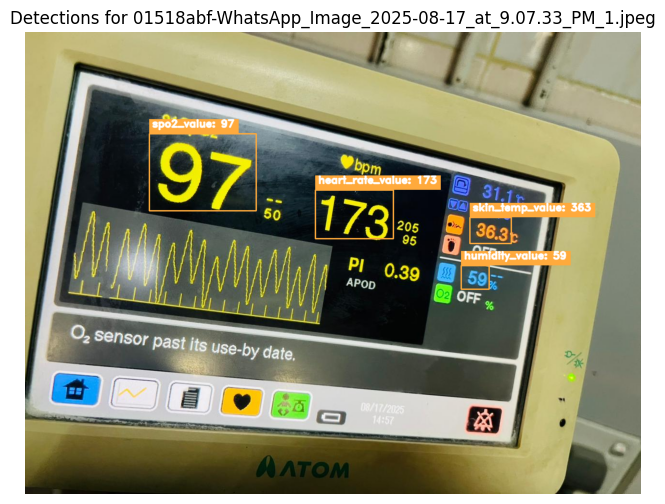

In [11]:
import easyocr
import re
import warnings
from pprint import pprint

# Suppress warnings temporarily for cleaner output
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    reader = easyocr.Reader(['en'], gpu=torch.cuda.is_available())

NUMERIC_CLASSES = [c for c in CLASS_NAMES if c.endswith('value')]

def preprocess_roi(roi):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    return cv2.resize(blur, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_CUBIC)

def clean_numeric(text):
    cleaned = re.sub(r'[^0-9.%]', '', text)
    cleaned = cleaned.replace('..', '.')
    return cleaned.strip('.')

def extract_value(roi):
    if roi.size == 0:
        return None, 0.0
    processed = preprocess_roi(roi)
    results = reader.readtext(processed, detail=1)
    if not results:
        return None, 0.0
    best = max(results, key=lambda x: x[2])
    _, raw_text, confidence = best
    text = clean_numeric(raw_text)
    return text or None, float(confidence)

TEXT_COLOR = (255, 255, 255)  # white
BOX_COLOR_NUMERIC = (60, 170, 255)  # soft orange for numeric classes
BOX_COLOR_OTHER = (120, 200, 80)  # green for non-numeric
BOX_THICKNESS = 2
FONT = cv2.FONT_HERSHEY_DUPLEX
FONT_SCALE = 0.7
FONT_THICKNESS = 2

def draw_label(image, text, anchor, color):
    x, y = anchor
    text = text if text else ""
    (text_w, text_h), baseline = cv2.getTextSize(text, FONT, FONT_SCALE, FONT_THICKNESS)
    pad = 6
    y = max(y, text_h + pad)
    top_left = (x, y - text_h - pad)
    bottom_right = (x + text_w + 2 * pad, y + baseline)
    cv2.rectangle(image, top_left, bottom_right, color, thickness=-1)
    text_org = (x + pad, y - pad)
    cv2.putText(image, text, text_org, FONT, FONT_SCALE, TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

def run_ocr_on_detection(image_path, model, conf=0.25, return_debug=False):
    image = cv2.imread(str(image_path))
    annotated = image.copy() if return_debug else None
    results = model.predict(source=str(image_path), conf=conf, verbose=False)
    det = results[0]
    outputs = {}
    for box, cls, score in zip(det.boxes.xyxy.cpu().numpy(), det.boxes.cls.cpu().numpy(), det.boxes.conf.cpu().numpy()):
        cls = int(cls)
        name = CLASS_NAMES[cls]
        x1, y1, x2, y2 = map(int, box)
        x1, y1 = max(x1, 0), max(y1, 0)
        x2, y2 = min(x2, image.shape[1] - 1), min(y2, image.shape[0] - 1)
        roi = image[y1:y2, x1:x2]
        display_value = None
        if name in NUMERIC_CLASSES:
            text, ocr_score = extract_value(roi)
            outputs[name] = {
                'bbox': box.tolist(),
                'det_conf': float(score),
                'value': text,
                'ocr_conf': float(ocr_score)
            }
            display_value = text
        else:
            outputs[name] = {
                'bbox': box.tolist(),
                'det_conf': float(score)
            }
        if return_debug and roi.size != 0:
            color = BOX_COLOR_NUMERIC if name in NUMERIC_CLASSES else BOX_COLOR_OTHER
            cv2.rectangle(annotated, (x1, y1), (x2, y2), color, BOX_THICKNESS)
            label_text = f"{name}: {display_value}" if display_value else name
            draw_label(annotated, label_text, (x1, y1 - 8), color)
    if return_debug:
        return outputs, annotated
    return outputs

def ensure_image_paths():
    global image_paths
    if 'image_paths' not in globals() or not image_paths:
        patterns = ("*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG")
        discovered = []
        for pattern in patterns:
            discovered.extend(DATASET_DIR.glob(pattern))
        discovered = sorted({path.resolve() for path in discovered})
        if not discovered:
            raise RuntimeError(f"No images found in {DATASET_DIR}.")
        image_paths = discovered
        print(f"Loaded {len(image_paths)} images from dataset.")
    return image_paths

def ensure_detector():
    global detector
    if 'detector' in globals():
        return detector
    candidate_paths = [
        MODEL_DIR / 'incubator_yolov8n_v2.pt',
        PROJECT_DIR / 'notebooks' / 'incubator' / 'yolov8n-incubator' / 'weights' / 'best.pt',
        PROJECT_DIR / 'runs' / 'detect' / 'yolov8n-incubator' / 'weights' / 'best.pt'
    ]
    candidate_paths.extend(PROJECT_DIR.glob('notebooks/**/weights/best.pt'))
    seen = set()
    for candidate in candidate_paths:
        if candidate.exists():
            real_path = candidate.resolve()
            if real_path in seen:
                continue
            seen.add(real_path)
            try:
                display_path = real_path.relative_to(PROJECT_DIR)
            except ValueError:
                display_path = real_path
            print(f"Loading detector weights from {display_path}")
            detector = YOLO(str(real_path))
            return detector
    raise RuntimeError("No trained detector weights found. Run the training cell to produce a detector.")

try:
    ensure_image_paths()
    ensure_detector()
except RuntimeError as exc:
    print(exc)
    print("If you have not trained a model yet, run the training cell. Otherwise, place the exported weights under 'models/incubator_yolov8n.pt'.")
else:
    sample_path = image_paths[0]
    print(f"Running OCR sample on {sample_path.name}")
    result = run_ocr_on_detection(sample_path, detector, return_debug=True)
    if isinstance(result, tuple):
        sample_outputs, annotated_image = result
    else:
        sample_outputs = result
        annotated_image = None
    if sample_outputs:
        print("OCR outputs (per class):")
        pprint(sample_outputs)
        try:
            summary_df = pd.DataFrame.from_dict(sample_outputs, orient='index')
            display(summary_df)
        except Exception:
            pass
    else:
        print("No detections returned for this image. Try lowering the confidence threshold or verifying the detector's outputs.")
    if annotated_image is not None:
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Detections for {sample_path.name}")
        plt.axis('off')
        plt.show()

## Accuracy Validation

The complete system performance is evaluated using **multi-level metrics**:

### 1. Detection Metrics

- **mAP (mean Average Precision)** from YOLO evaluation
- Bounding box localization accuracy

### 2. OCR String Accuracy

- **Exact match rate** - Percentage of readings matching ground truth exactly
- Character-level accuracy for partially correct readings

### 3. Numeric Accuracy

- **MAE (Mean Absolute Error)** - Average absolute difference from ground truth
- **RMSE (Root Mean Square Error)** - Sensitivity to large errors
- Per-channel accuracy for each vital sign parameter

**Ground Truth Collection:** Manual labeling of a representative sample is required to compute these metrics accurately.

## Post-Processing and Value Validation

Raw OCR output requires **medical validation** to ensure readings are physiologically realistic. This section implements a comprehensive validation framework:

### Validation Components

1. **Range Validation** - Verify readings fall within medically acceptable bounds for neonatal vital signs
2. **Decimal Correction** - Automatically fix common OCR errors (e.g., missing decimal points: 356 to 35.6)
3. **Integer Enforcement** - Remove inappropriate decimal points from integer-only values (heart rate, humidity, SpO2)
4. **Confidence Filtering** - Reject predictions below minimum OCR confidence threshold

### Medical Range Definitions

The system defines realistic bounds for each parameter based on **neonatal clinical standards**:
- Heart Rate: 60-220 bpm (integer)
- Humidity: 30-95% (integer)
- Skin Temperature: 32.0-39.0 degrees Celsius (1 decimal place)
- SpO2: 70-100% (integer)

### Validation Strategy

**For Single Image Analysis:** Invalid readings are rejected (output as None) rather than replaced.

**Important Note:** This implementation does **not** use temporal smoothing (previous value retention). Temporal smoothing with frame-to-frame state management is only applicable for **live video streams** in production deployment.


### Ground Truth Template Creation

This cell generates a **ground truth template file** to facilitate manual labeling for accuracy evaluation:

**Function:** `create_ground_truth_template()`

**Features:**

- Creates a JSON file with sampled images
- Optionally includes model predictions to speed up labeling
- Defines empty slots for manual ground truth entry
- Uses relative paths for portability

**Process:**

1. Randomly samples images from the dataset
2. Runs OCR predictions on each image (if enabled)
3. Creates JSON structure with image paths and empty value fields
4. Saves template to `ground_truth.json`

**Template Structure:**

```json
{
  "image_path": "dataset/image.jpg",
  "values": {
    "heart_rate_value": null,
    "humidity_value": null,
    "skin_temp_value": null,
    "spo2_value": null
  },
  "predicted": {
    "heart_rate_value": "145",
    ...
  }
}
```

**Usage:** After generation, manually fill in the `values` fields with correct readings from the actual images for accuracy computation.

**Note:** Uncomment the function call at the bottom when ready to generate the template.


In [15]:
def evaluate_ocr(predictions, ground_truth):
    # predictions: list of dicts with 'value' keys per class
    # ground_truth: list of dicts with same structure but numeric str
    rows = []
    for pred, gt in zip(predictions, ground_truth):
        row = {}
        for cls in NUMERIC_CLASSES:
            pred_val = pred.get(cls, {}).get('value')
            true_val = gt.get(cls) if isinstance(gt, dict) else None
            if pred_val is None or true_val is None:
                continue
            row[f'{cls}_match'] = int(pred_val == true_val)
            try:
                row[f'{cls}_ae'] = abs(float(pred_val) - float(true_val))
            except (ValueError, TypeError):
                row[f'{cls}_ae'] = np.nan
        if row:
            rows.append(row)
    if not rows:
        return pd.DataFrame(columns=[f'{cls}_match' for cls in NUMERIC_CLASSES])
    df = pd.DataFrame(rows)
    return df

GROUND_TRUTH_PATH = PROJECT_DIR / 'ground_truth.json'

if GROUND_TRUTH_PATH.exists():
    print(f"Loading ground truth from {GROUND_TRUTH_PATH}")
    try:
        with open(GROUND_TRUTH_PATH, 'r', encoding='utf-8') as f:
            gt_records = json.load(f)
    except json.JSONDecodeError as exc:
        print(f"Failed to parse ground_truth.json: {exc}")
        gt_records = []
    if gt_records:
        preds = []
        gt_values = []
        comparison_rows = []
        skipped = 0
        for rec in gt_records:
            image_path = rec.get('image_path')
            values = rec.get('values') or {}
            if image_path is None or not isinstance(values, dict):
                skipped += 1
                continue
            image_path = Path(image_path)
            if not image_path.is_absolute():
                image_path = PROJECT_DIR / image_path
            if not image_path.exists():
                print(f"Warning: image path not found -> {image_path}")
                skipped += 1
                continue
            prediction = run_ocr_on_detection(image_path, detector)
            preds.append(prediction)
            gt_values.append(values)
            row = {'image_path': to_project_relative(image_path)}
            for cls in NUMERIC_CLASSES:
                row[f'{cls}_pred'] = prediction.get(cls, {}).get('value')
                row[f'{cls}_gt'] = values.get(cls)
            comparison_rows.append(row)
        if comparison_rows:
            comparison_df = pd.DataFrame(comparison_rows)
            display(comparison_df)
            gt_cols = [c for c in comparison_df.columns if c.endswith('_gt')]
            if gt_cols and comparison_df[gt_cols].isna().all().all():
                print("All ground-truth slots are still empty. Fill the *_gt columns in ground_truth.json to compute accuracy metrics.")
        if preds:
            metrics_df = evaluate_ocr(preds, gt_values)
            if not metrics_df.empty:
                display(metrics_df)
                print("Averaged metrics:")
                display(metrics_df.mean(numeric_only=True))
            else:
                print("No rows with both prediction and ground truth values yet. Populate ground_truth.json to enable metrics.")
            if skipped:
                print(f"Skipped {skipped} record(s) due to missing data.")
        else:
            print("No valid records to evaluate. Verify paths and values in ground_truth.json.")
    else:
        print("ground_truth.json is empty. Add records to evaluate OCR accuracy.")
else:
    print("No ground_truth.json found. Create this file with labeled values to compute OCR metrics.")

Loading ground truth from c:\Users\sahan\Desktop\MYProjects\Neonatal_incubator_displayReader\ground_truth.json


c:\Users\sahan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


,image_path,heart_rate_value_pred,heart_rate_value_gt,humidity_value_pred,humidity_value_gt,skin_temp_value_pred,skin_temp_value_gt,spo2_value_pred,spo2_value_gt
0,dataset\34b3ff00-90b6-4a45-896b-bec14cf4863c.jpg,173,173,59,59,36.3,36.3,97,97
1,dataset\097f44f5-96a1-4ddb-a5a5-4310361977f8.jpg,175,175,59,59,363,36.3,99,99
2,dataset\8511a8b5-e73f-49e0-a7e4-c226d0ecd222.jpg,47,172,50,59,36,36.3,None,96
3,dataset\75d82643-83ab-49da-b94d-9a4cc5c782fc.jpg,149,149,None,77,35.9,35.9,93,93
4,dataset\ff5eac4e-c64f-4f1f-abb9-1ccfae613857.jpg,153,153,56,56,87.6,37.6,97,97
5,dataset\1fa563c5-9fb7-483a-99fd-e65914eeeef5.jpg,158,158,66,56,07.6,37.6,98,98
6,dataset\b5b5d5aa-1e44-452a-b066-29065b3b3efb.jpg,175,175,60,60,863,36.3,98,98
7,dataset\139c5afb-b8d4-4b37-b42c-35fd27f39651.jpg,176,176,59,59,362,36.2,98,98
8,dataset\a657b440-5e78-4b61-a4b8-3654a0445003.jpg,151,151,None,77,357,35.7,91,91
9,dataset\b6796246-b85e-4dfc-83b3-94bc12c92c07.jpg,159,159,56,56,876,37.6,97,97


,heart_rate_value_match,heart_rate_value_ae,humidity_value_match,humidity_value_ae,skin_temp_value_match,skin_temp_value_ae,spo2_value_match,spo2_value_ae
0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0,326.7,0.0,0.0
2,0.0,125.0,0.0,9.0,0,0.3,NaN,NaN
3,0.0,0.0,NaN,NaN,0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0,50.0,0.0,0.0
5,0.0,0.0,0.0,10.0,0,30.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0,826.7,0.0,0.0
7,0.0,0.0,0.0,0.0,0,325.8,0.0,0.0
8,0.0,0.0,NaN,NaN,0,321.3,0.0,0.0
9,0.0,0.0,0.0,0.0,0,838.4,0.0,0.0


Averaged metrics:


heart_rate_value_match      0.000000
heart_rate_value_ae        21.875000
humidity_value_match        0.000000
humidity_value_ae           3.761905
skin_temp_value_match       0.000000
skin_temp_value_ae        427.980000
spo2_value_match            0.000000
spo2_value_ae               0.000000
dtype: float64

### Accuracy Evaluation Against Ground Truth

This cell computes **accuracy metrics** by comparing OCR predictions against manually labeled ground truth:

**Function:** `evaluate_ocr()`

**Metrics Computed:**

- **Exact Match** - Binary indicator (1 or 0) if prediction exactly matches ground truth
- **Absolute Error (AE)** - Absolute difference between predicted and true numeric values

**Process:**

1. Loads ground truth data from `ground_truth.json`
2. Runs OCR predictions on each ground truth image
3. Compares predictions to ground truth values
4. Generates comparison DataFrame showing predicted vs. actual values
5. Computes match rates and absolute errors per parameter
6. Calculates averaged metrics across all samples

**Output:**

- Side-by-side comparison table (predicted vs. ground truth)
- Per-image metrics (match rate, absolute error)
- Averaged statistics across all evaluated images
- Warning if ground truth slots are empty

**Note:** Requires `ground_truth.json` file with manually labeled values to be present in the project directory.


## Post-processing and value validation

After OCR extraction, we need to validate that readings fall within realistic medical ranges and apply corrections for common OCR errors (e.g., missing decimal points, transposed digits). This section implements:

1. **Range validation** - Define realistic bounds for each vital sign
2. **Decimal correction** - Fix missing/misplaced decimal points (e.g., 356 → 35.6)
3. **Integer enforcement** - Remove decimal points from integer-only values (heart rate, humidity, SpO2)
4. **Confidence-based filtering** - Reject low-confidence predictions

**Note:** Invalid/unusual values are rejected (shown as None) rather than replaced with previous values. Previous value smoothing is only applicable for live video streams, not single image analysis.


In [26]:
# Define realistic medical ranges for neonatal incubator vital signs
VALUE_RANGES = {
    'heart_rate_value': {
        'min': 60,
        'max': 220,
        'decimals': 0,
        'unit': 'bpm',
        'description': 'Heart Rate',
        'integer_only': True  # Heart rate is always an integer
    },
    'humidity_value': {
        'min': 30,
        'max': 95,
        'decimals': 0,
        'unit': '%',
        'description': 'Humidity',
        'integer_only': True  # Humidity is always an integer
    },
    'skin_temp_value': {
        'min': 32.0,
        'max': 39.0,
        'decimals': 1,
        'unit': '°C',
        'description': 'Skin Temperature',
        'integer_only': False  # Can have decimal (e.g., 36.5°C)
    },
    'spo2_value': {
        'min': 70,
        'max': 100,
        'decimals': 0,
        'unit': '%',
        'description': 'SpO2',
        'integer_only': True  # SpO2 is always an integer
    }
}

def try_fix_decimal(value_str, expected_decimals, min_val, max_val, integer_only=False):
    """
    Attempt to fix missing or misplaced decimal points.
    
    Example: '356' with expected_decimals=1, range 32-39 → '35.6'
    For integer_only values (heart_rate, spo2): removes any decimal points
    """
    if not value_str or not value_str.replace('.', '').replace('%', '').isdigit():
        return None
    
    # Remove any non-numeric characters except decimal
    clean = value_str.replace('%', '').strip()
    
    # For integer-only values (heart rate, SpO2), remove decimals
    if integer_only:
        if '.' in clean:
            # Remove decimal point and everything after it
            clean = clean.split('.')[0]
        try:
            val = int(clean)
            if min_val <= val <= max_val:
                return str(val)
        except ValueError:
            pass
        return None
    
    # If already has correct decimal places and in range, return as-is
    try:
        val = float(clean)
        if min_val <= val <= max_val:
            return clean
    except ValueError:
        pass
    
    # Try to fix missing decimal point
    if expected_decimals > 0 and '.' not in clean:
        # Try inserting decimal at various positions
        for i in range(len(clean) - expected_decimals, 0, -1):
            candidate = clean[:i] + '.' + clean[i:]
            try:
                val = float(candidate)
                if min_val <= val <= max_val:
                    return candidate
            except ValueError:
                continue
    
    # Try removing extra zeros
    if clean.startswith('0') and len(clean) > 1:
        clean = clean.lstrip('0')
        try:
            val = float(clean)
            if min_val <= val <= max_val:
                return clean
        except ValueError:
            pass
    
    return None

def validate_and_correct_value(class_name, raw_value, ocr_confidence=0.0, min_confidence=0.5):
    """
    Validate OCR reading against expected ranges and apply corrections.
    
    Returns:
        dict with keys: 'valid', 'corrected_value', 'raw_value', 'issues'
    """
    if class_name not in VALUE_RANGES:
        return {
            'valid': False,
            'corrected_value': None,
            'raw_value': raw_value,
            'issues': ['Unknown class']
        }
    
    config = VALUE_RANGES[class_name]
    issues = []
    
    # Check confidence
    if ocr_confidence < min_confidence:
        issues.append(f'Low OCR confidence: {ocr_confidence:.2f} < {min_confidence}')
    
    # Check if value exists
    if raw_value is None or raw_value == '':
        return {
            'valid': False,
            'corrected_value': None,
            'raw_value': raw_value,
            'issues': ['No value detected']
        }
    
    # Try to parse as number
    corrected = None
    integer_only = config.get('integer_only', False)
    
    try:
        val = float(str(raw_value).replace('%', '').strip())
        
        # For integer-only values, convert to int
        if integer_only:
            val = int(val)
        
        if config['min'] <= val <= config['max']:
            corrected = str(int(val)) if integer_only else str(val)
        else:
            issues.append(f"Out of range: {val} not in [{config['min']}, {config['max']}]")
    except ValueError:
        issues.append(f"Cannot parse as number: '{raw_value}'")
    
    # If initial parse failed or out of range, try fixing decimal
    if corrected is None:
        fixed = try_fix_decimal(
            str(raw_value),
            config['decimals'],
            config['min'],
            config['max'],
            integer_only=integer_only
        )
        if fixed:
            corrected = fixed
            correction_msg = f"Removed decimal from integer value: {raw_value} → {fixed}" if integer_only and '.' in str(raw_value) else f"Applied decimal correction: {raw_value} → {fixed}"
            issues.append(correction_msg)
    
    return {
        'valid': corrected is not None,
        'corrected_value': corrected,
        'raw_value': raw_value,
        'issues': issues if issues else None
    }

def apply_postprocessing(predictions, min_confidence=0.5):
    """
    Apply validation and corrections to OCR predictions.
    
    Args:
        predictions: dict of class_name -> {value, det_conf, ocr_conf, bbox}
        min_confidence: minimum OCR confidence threshold
        
    Returns:
        dict with corrected predictions and validation metadata
    """
    corrected = {}
    validation_log = {}
    
    for class_name in NUMERIC_CLASSES:
        if class_name not in predictions:
            # No detection for this class - leave as None
            validation_log[class_name] = {
                'status': 'not_detected',
                'issues': ['No detection for this parameter']
            }
            continue
        
        pred_data = predictions[class_name]
        raw_value = pred_data.get('value')
        ocr_conf = pred_data.get('ocr_conf', 0.0)
        det_conf = pred_data.get('det_conf', 0.0)
        
        # Validate and correct
        result = validate_and_correct_value(
            class_name,
            raw_value,
            ocr_conf,
            min_confidence
        )
        
        if result['valid']:
            # Use corrected value
            corrected[class_name] = {
                'value': result['corrected_value'],
                'raw_value': result['raw_value'],
                'source': 'ocr_corrected' if result['issues'] else 'ocr_direct',
                'det_conf': det_conf,
                'ocr_conf': ocr_conf,
                'bbox': pred_data.get('bbox')
            }
            
            validation_log[class_name] = {
                'status': 'valid',
                'issues': result['issues']
            }
        else:
            # Invalid - reject the value (don't use previous value for single images)
            validation_log[class_name] = {
                'status': 'invalid',
                'issues': result['issues']
            }
            # Don't add to corrected dict - this parameter will show as None/missing
    
    return {
        'corrected_predictions': corrected,
        'validation_log': validation_log
    }

# Display validation configuration
print("=" * 80)
print("VALUE VALIDATION RANGES")
print("=" * 80)
for class_name, config in VALUE_RANGES.items():
    print(f"\n{config['description']} ({class_name}):")
    print(f"  Range: {config['min']} - {config['max']} {config['unit']}")
    print(f"  Decimals: {config['decimals']}")
print("\n" + "=" * 80)

VALUE VALIDATION RANGES

Heart Rate (heart_rate_value):
  Range: 60 - 220 bpm
  Decimals: 0

Humidity (humidity_value):
  Range: 30 - 95 %
  Decimals: 0

Skin Temperature (skin_temp_value):
  Range: 32.0 - 39.0 °C
  Decimals: 1

SpO2 (spo2_value):
  Range: 70 - 100 %
  Decimals: 0



### Medical Range Validation Configuration

This cell defines the **validation framework** for ensuring OCR readings are medically accurate:

**VALUE_RANGES Dictionary:**

Defines validation parameters for each vital sign:

1. **Heart Rate (60-220 bpm)**

   - Integer-only values
   - No decimal places
   - Critical neonatal range

2. **Humidity (30-95%)**

   - Integer-only values
   - Environment control parameter

3. **Skin Temperature (32.0-39.0°C)**

   - Allows 1 decimal place
   - Precise temperature monitoring

4. **SpO2 (70-100%)**
   - Integer-only values
   - Oxygen saturation monitoring

**Validation Functions:**

1. **`try_fix_decimal()`** - Automatically corrects decimal point errors:

   - Inserts missing decimals (356 → 35.6)
   - Removes inappropriate decimals from integers
   - Validates against acceptable ranges

2. **`validate_and_correct_value()`** - Comprehensive validation:

   - Checks OCR confidence threshold
   - Validates numeric range
   - Applies decimal corrections if needed
   - Returns validation status and corrected value

3. **`apply_postprocessing()`** - Batch processing:
   - Validates all predictions in a result dictionary
   - Applies corrections where possible
   - Rejects invalid readings
   - Returns corrected predictions with validation log

**Output:** Displays configured validation ranges for review.


### Testing Post-Processing Logic

This section demonstrates the **validation and correction capabilities** on sample predictions to verify proper handling of various edge cases:

- Missing decimal points in temperature readings
- Inappropriate decimal points in integer values
- Out-of-range readings
- Low confidence predictions

The test results show how the system automatically applies corrections while maintaining medical accuracy.


In [27]:
# Test with sample predictions to demonstrate correction capabilities
test_predictions = {
    'skin_temp_value': {'value': '356', 'ocr_conf': 0.85, 'det_conf': 0.92},  # Missing decimal → 35.6
    'heart_rate_value': {'value': '145.5', 'ocr_conf': 0.90, 'det_conf': 0.88},  # Has decimal, should remove → 145
    'humidity_value': {'value': '65.2', 'ocr_conf': 0.75, 'det_conf': 0.85},  # Has decimal, should remove → 65
    'spo2_value': {'value': '98.7', 'ocr_conf': 0.88, 'det_conf': 0.91}  # Has decimal, should remove → 98
}

print("TESTING POST-PROCESSING LOGIC")
print("=" * 80)
print("\nRaw OCR Predictions:")
for cls, data in test_predictions.items():
    config = VALUE_RANGES.get(cls, {})
    desc = config.get('description', cls)
    print(f"  {desc}: {data['value']} (OCR conf: {data['ocr_conf']:.2f})")

# Apply post-processing
result = apply_postprocessing(test_predictions, min_confidence=0.5)

print("\n" + "=" * 80)
print("CORRECTED VALUES:")
print("=" * 80)
for cls in NUMERIC_CLASSES:
    config = VALUE_RANGES.get(cls, {})
    desc = config.get('description', cls)
    
    if cls in result['corrected_predictions']:
        corr_data = result['corrected_predictions'][cls]
        val_log = result['validation_log'][cls]
        
        print(f"\n{desc}:")
        print(f"  Corrected: {corr_data['value']} (source: {corr_data['source']})")
        if 'raw_value' in corr_data and corr_data['raw_value'] != corr_data['value']:
            print(f"  Original: {corr_data['raw_value']}")
        print(f"  Status: {val_log['status']}")
        if val_log.get('issues'):
            print(f"  Issues: {', '.join(val_log['issues'])}")
    else:
        val_log = result['validation_log'].get(cls, {})
        print(f"\n{desc}:")
        print(f"  Status: {val_log.get('status', 'unknown')}")
        if val_log.get('issues'):
            print(f"  Issues: {', '.join(val_log['issues'])}")

print("\n" + "=" * 80)

TESTING POST-PROCESSING LOGIC

Raw OCR Predictions:
  Skin Temperature: 356 (OCR conf: 0.85)
  Heart Rate: 145.5 (OCR conf: 0.90)
  Humidity: 65.2 (OCR conf: 0.75)
  SpO2: 98.7 (OCR conf: 0.88)

CORRECTED VALUES:

Heart Rate:
  Corrected: 145 (source: ocr_direct)
  Original: 145.5
  Status: valid

Humidity:
  Corrected: 65 (source: ocr_direct)
  Original: 65.2
  Status: valid

Skin Temperature:
  Corrected: 35.6 (source: ocr_corrected)
  Original: 356
  Status: valid
  Issues: Out of range: 356.0 not in [32.0, 39.0], Applied decimal correction: 356 → 35.6

SpO2:
  Corrected: 98 (source: ocr_direct)
  Original: 98.7
  Status: valid



### Test Validation on Sample Data

This cell demonstrates the **post-processing validation** on synthetic test cases:

**Test Cases:**

- **Skin Temperature:** "356" → Should correct to "35.6" (missing decimal)
- **Heart Rate:** "145.5" → Should correct to "145" (remove inappropriate decimal)
- **Humidity:** "65.2" → Should correct to "65" (integer-only value)
- **SpO2:** "98.7" → Should correct to "98" (integer-only value)

**Process:**

1. Creates dictionary of test predictions with intentional errors
2. Applies `apply_postprocessing()` function
3. Displays raw OCR predictions
4. Shows corrected values with applied corrections
5. Reports validation status and any issues detected

**Purpose:** Verifies that the validation logic correctly:

- Fixes missing decimal points in temperature readings
- Removes inappropriate decimals from integer parameters
- Maintains confidence score tracking
- Properly categorizes correction types (ocr_direct vs. ocr_corrected)

**Output:** Formatted comparison showing raw input, corrected output, and applied corrections for each parameter.


### Re-Evaluation with Post-Processing

This section re-runs the **accuracy evaluation** with post-processing validation enabled to measure the improvement in prediction quality.

**Comparison Metrics:**

- Raw OCR accuracy vs. Post-processed accuracy
- Reduction in absolute error
- Number of corrections applied
- Number of invalid readings rejected

The results demonstrate the effectiveness of the validation framework in improving overall system reliability.


In [29]:
if GROUND_TRUTH_PATH.exists():
    print("=" * 80)
    print("ACCURACY EVALUATION WITH POST-PROCESSING")
    print("=" * 80)
    print(f"\nLoading ground truth from {GROUND_TRUTH_PATH.relative_to(PROJECT_DIR)}")
    
    try:
        with open(GROUND_TRUTH_PATH, 'r', encoding='utf-8') as f:
            gt_records = json.load(f)
    except json.JSONDecodeError as exc:
        print(f"Failed to parse ground_truth.json: {exc}")
        gt_records = []
  
    if gt_records:
        # Collect raw and corrected predictions
        raw_preds = []
        corrected_preds = []
        gt_values = []
        comparison_rows = []
        correction_stats = {
            'total_predictions': 0,
            'corrections_applied': 0,
            'invalid_rejected': 0
        }
        
        skipped = 0
        
        for rec in gt_records:
            image_path = rec.get('image_path')
            values = rec.get('values') or {}
            
            if image_path is None or not isinstance(values, dict):
                skipped += 1
                continue
            
            image_path = Path(image_path)
            if not image_path.is_absolute():
                image_path = PROJECT_DIR / image_path
            
            if not image_path.exists():
                print(f"Warning: image path not found -> {image_path}")
                skipped += 1
                continue
            
            # Get raw OCR prediction
            raw_prediction = run_ocr_on_detection(image_path, detector)
            raw_preds.append(raw_prediction)
            
            # Apply post-processing
            pp_result = apply_postprocessing(
                raw_prediction,
                min_confidence=0.5
            )
            
            corrected_prediction = pp_result['corrected_predictions']
            val_log = pp_result['validation_log']
            
            corrected_preds.append(corrected_prediction)
            gt_values.append(values)
            
            # Build comparison row
            row = {'image_path': to_project_relative(image_path)}
            for cls in NUMERIC_CLASSES:
                # Raw value
                row[f'{cls}_raw'] = raw_prediction.get(cls, {}).get('value')
                # Corrected value
                row[f'{cls}_corrected'] = corrected_prediction.get(cls, {}).get('value')
                # Ground truth
                row[f'{cls}_gt'] = values.get(cls)
                # Source (ocr_direct, ocr_corrected)
                row[f'{cls}_source'] = corrected_prediction.get(cls, {}).get('source', 'N/A')
            
            comparison_rows.append(row)
            
            # Update correction statistics
            for cls in NUMERIC_CLASSES:
                if cls in raw_prediction:
                    correction_stats['total_predictions'] += 1
                    
                    if val_log.get(cls, {}).get('status') == 'valid' and val_log.get(cls, {}).get('issues'):
                        correction_stats['corrections_applied'] += 1
                    
                    if val_log.get(cls, {}).get('status') == 'invalid':
                        correction_stats['invalid_rejected'] += 1
        
        # Display comparison DataFrame
        if comparison_rows:
            print(f"\nProcessed {len(comparison_rows)} images")
            comparison_df = pd.DataFrame(comparison_rows)
            
            # Reorder columns for better readability
            ordered_cols = ['image_path']
            for cls in NUMERIC_CLASSES:
                ordered_cols.extend([f'{cls}_raw', f'{cls}_corrected', f'{cls}_source', f'{cls}_gt'])
            ordered_cols = [c for c in ordered_cols if c in comparison_df.columns]
            comparison_df = comparison_df[ordered_cols]
            
            print("\n" + "=" * 80)
            print("COMPARISON: Raw vs Corrected vs Ground Truth")
            print("=" * 80)
            display(comparison_df)
            
            # Check if ground truth is populated
            gt_cols = [c for c in comparison_df.columns if c.endswith('_gt')]
            if gt_cols and comparison_df[gt_cols].isna().all().all():
                print("\n  All ground-truth slots are empty. Fill the *_gt columns in ground_truth.json to compute accuracy metrics.")
        
        # Compute metrics for both raw and corrected predictions
        if raw_preds and corrected_preds:
            print("\n" + "=" * 80)
            print("ACCURACY METRICS")
            print("=" * 80)
            
            # Raw OCR metrics
            print("\n RAW OCR (without post-processing):")
            raw_metrics_df = evaluate_ocr(raw_preds, gt_values)
            if not raw_metrics_df.empty:
                display(raw_metrics_df)
                print("\nAveraged raw metrics:")
                raw_avg = raw_metrics_df.mean(numeric_only=True)
                display(raw_avg)
            else:
                print("No rows with both prediction and ground truth values yet.")
                raw_avg = None
            
            # Corrected metrics
            print("\n CORRECTED (with post-processing):")
            corrected_metrics_df = evaluate_ocr(corrected_preds, gt_values)
            if not corrected_metrics_df.empty:
                display(corrected_metrics_df)
                print("\nAveraged corrected metrics:")
                corrected_avg = corrected_metrics_df.mean(numeric_only=True)
                display(corrected_avg)
            else:
                print("No rows with both prediction and ground truth values yet.")
                corrected_avg = None
            
            # Improvement summary
            if raw_avg is not None and corrected_avg is not None:
                print("\n" + "=" * 80)
                print("IMPROVEMENT SUMMARY")
                print("=" * 80)
                
                match_cols = [c for c in raw_avg.index if c.endswith('_match')]
                if match_cols:
                    print("\nAccuracy (exact match rate):")
                    for col in match_cols:
                        cls_name = col.replace('_match', '')
                        raw_acc = raw_avg[col] * 100 if col in raw_avg.index else 0
                        corr_acc = corrected_avg[col] * 100 if col in corrected_avg.index else 0
                        improvement = corr_acc - raw_acc
                        status = "✓" if improvement >= 0 else "✗"
                        print(f"  {cls_name}: {raw_acc:.1f}% → {corr_acc:.1f}% ({improvement:+.1f}%) {status}")
                
                ae_cols = [c for c in raw_avg.index if c.endswith('_ae')]
                if ae_cols:
                    print("\nAbsolute Error (lower is better):")
                    for col in ae_cols:
                        cls_name = col.replace('_ae', '')
                        raw_ae = raw_avg[col] if col in raw_avg.index else float('nan')
                        corr_ae = corrected_avg[col] if col in corrected_avg.index else float('nan')
                        if not np.isnan(raw_ae) and not np.isnan(corr_ae):
                            improvement = raw_ae - corr_ae
                            status = "✓" if improvement >= 0 else "✗"
                            print(f"  {cls_name}: {raw_ae:.2f} → {corr_ae:.2f} ({improvement:+.2f}) {status}")
            
            # Post-processing statistics
            print("\n" + "=" * 80)
            print("POST-PROCESSING STATISTICS")
            print("=" * 80)
            print(f"Total predictions: {correction_stats['total_predictions']}")
            print(f"Corrections applied: {correction_stats['corrections_applied']}")
            print(f"Invalid rejected: {correction_stats['invalid_rejected']}")
            
            if skipped:
                print(f"\n  Skipped {skipped} record(s) due to missing data.")
        else:
            print("\nNo valid records to evaluate. Verify paths and values in ground_truth.json.")
    else:
        print("ground_truth.json is empty. Add records to evaluate OCR accuracy.")
else:
    print("No ground_truth.json found. Create this file with labeled values to compute OCR metrics.")

ACCURACY EVALUATION WITH POST-PROCESSING

Loading ground truth from ground_truth.json


c:\Users\sahan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Processed 25 images

COMPARISON: Raw vs Corrected vs Ground Truth


,image_path,heart_rate_value_raw,heart_rate_value_corrected,heart_rate_value_source,heart_rate_value_gt,humidity_value_raw,humidity_value_corrected,humidity_value_source,humidity_value_gt,skin_temp_value_raw,skin_temp_value_corrected,skin_temp_value_source,skin_temp_value_gt,spo2_value_raw,spo2_value_corrected,spo2_value_source,spo2_value_gt
0,dataset\34b3ff00-90b6-4a45-896b-bec14cf4863c.jpg,173,173,ocr_direct,173,59,59,ocr_direct,59,36.3,36.3,ocr_direct,36.3,97,97,ocr_direct,97
1,dataset\097f44f5-96a1-4ddb-a5a5-4310361977f8.jpg,175,175,ocr_direct,175,59,59,ocr_direct,59,363,36.3,ocr_corrected,36.3,99,99,ocr_direct,99
2,dataset\8511a8b5-e73f-49e0-a7e4-c226d0ecd222.jpg,47,None,N/A,172,50,50,ocr_corrected,59,36,36.0,ocr_direct,36.3,None,None,N/A,96
3,dataset\75d82643-83ab-49da-b94d-9a4cc5c782fc.jpg,149,149,ocr_direct,149,None,None,N/A,77,35.9,35.9,ocr_corrected,35.9,93,93,ocr_direct,93
4,dataset\ff5eac4e-c64f-4f1f-abb9-1ccfae613857.jpg,153,153,ocr_direct,153,56,56,ocr_direct,56,87.6,None,N/A,37.6,97,97,ocr_direct,97
5,dataset\1fa563c5-9fb7-483a-99fd-e65914eeeef5.jpg,158,158,ocr_direct,158,66,66,ocr_direct,56,07.6,None,N/A,37.6,98,98,ocr_direct,98
6,dataset\b5b5d5aa-1e44-452a-b066-29065b3b3efb.jpg,175,175,ocr_direct,175,60,60,ocr_direct,60,863,None,N/A,36.3,98,98,ocr_direct,98
7,dataset\139c5afb-b8d4-4b37-b42c-35fd27f39651.jpg,176,176,ocr_direct,176,59,59,ocr_direct,59,362,36.2,ocr_corrected,36.2,98,98,ocr_direct,98
8,dataset\a657b440-5e78-4b61-a4b8-3654a0445003.jpg,151,151,ocr_direct,151,None,None,N/A,77,357,35.7,ocr_corrected,35.7,91,91,ocr_direct,91
9,dataset\b6796246-b85e-4dfc-83b3-94bc12c92c07.jpg,159,159,ocr_direct,159,56,56,ocr_direct,56,876,None,N/A,37.6,97,97,ocr_direct,97



ACCURACY METRICS

 RAW OCR (without post-processing):


,heart_rate_value_match,heart_rate_value_ae,humidity_value_match,humidity_value_ae,skin_temp_value_match,skin_temp_value_ae,spo2_value_match,spo2_value_ae
0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0,326.7,0.0,0.0
2,0.0,125.0,0.0,9.0,0,0.3,NaN,NaN
3,0.0,0.0,NaN,NaN,0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0,50.0,0.0,0.0
5,0.0,0.0,0.0,10.0,0,30.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0,826.7,0.0,0.0
7,0.0,0.0,0.0,0.0,0,325.8,0.0,0.0
8,0.0,0.0,NaN,NaN,0,321.3,0.0,0.0
9,0.0,0.0,0.0,0.0,0,838.4,0.0,0.0



Averaged raw metrics:


heart_rate_value_match      0.000000
heart_rate_value_ae        21.875000
humidity_value_match        0.000000
humidity_value_ae           3.761905
skin_temp_value_match       0.000000
skin_temp_value_ae        427.980000
spo2_value_match            0.000000
spo2_value_ae               0.000000
dtype: float64


 CORRECTED (with post-processing):


,heart_rate_value_match,heart_rate_value_ae,humidity_value_match,humidity_value_ae,skin_temp_value_match,skin_temp_value_ae,spo2_value_match,spo2_value_ae
0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,NaN,NaN,0.0,9.0,0.0,0.30,NaN,NaN
3,0.0,0.0,NaN,NaN,0.0,0.00,0.0,0.0
4,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
5,0.0,0.0,0.0,10.0,NaN,NaN,0.0,0.0
6,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
8,0.0,0.0,NaN,NaN,0.0,0.00,0.0,0.0
9,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0



Averaged corrected metrics:


heart_rate_value_match    0.000000
heart_rate_value_ae       0.000000
humidity_value_match      0.000000
humidity_value_ae         0.950000
skin_temp_value_match     0.000000
skin_temp_value_ae        0.101176
spo2_value_match          0.000000
spo2_value_ae             0.000000
dtype: float64


IMPROVEMENT SUMMARY

Accuracy (exact match rate):
  heart_rate_value: 0.0% → 0.0% (+0.0%) ✓
  humidity_value: 0.0% → 0.0% (+0.0%) ✓
  skin_temp_value: 0.0% → 0.0% (+0.0%) ✓
  spo2_value: 0.0% → 0.0% (+0.0%) ✓

Absolute Error (lower is better):
  heart_rate_value: 21.88 → 0.00 (+21.88) ✓
  humidity_value: 3.76 → 0.95 (+2.81) ✓
  skin_temp_value: 427.98 → 0.10 (+427.88) ✓
  spo2_value: 0.00 → 0.00 (+0.00) ✓

POST-PROCESSING STATISTICS
Total predictions: 100
Corrections applied: 15
Invalid rejected: 18


### Compare Raw vs. Post-Processed Accuracy

This cell performs **comprehensive accuracy evaluation** comparing raw OCR output against post-processed predictions:

**Evaluation Process:**

1. **Load Ground Truth** - Reads manually labeled data from `ground_truth.json`

2. **Dual Prediction**:

   - Generates raw OCR predictions without validation
   - Applies post-processing with medical validation

3. **Comparison Analysis**:

   - Creates side-by-side comparison table (raw, corrected, source, ground truth)
   - Tracks correction statistics (total predictions, corrections applied, invalid rejected)

4. **Metrics Computation**:

   - **Raw Metrics** - Accuracy without post-processing
   - **Corrected Metrics** - Accuracy with validation enabled
   - **Improvement Analysis** - Shows percentage improvement in accuracy and error reduction

5. **Statistical Summary**:
   - Exact match rate comparison
   - Absolute error comparison
   - Post-processing impact statistics

**Key Outputs:**

- Comparison DataFrame with all four value columns per parameter
- Raw vs. Corrected accuracy metrics side-by-side
- Improvement summary with visual indicators
- Post-processing statistics (corrections applied, invalid rejected)

**Purpose:** Demonstrates the effectiveness of medical validation in improving prediction reliability and reducing errors.


### Visualization of Corrections

This section provides **side-by-side comparison** of raw OCR output and corrected values with visual annotations.

**Display Components:**

- Annotated image with bounding boxes
- Comparison table showing raw vs. corrected values
- Validation status for each parameter
- List of corrections applied (if any)

This visualization helps understand the post-processing behavior and verify correct operation.


Running post-processing visualization on sample images...


SAMPLE 1/3


c:\Users\sahan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


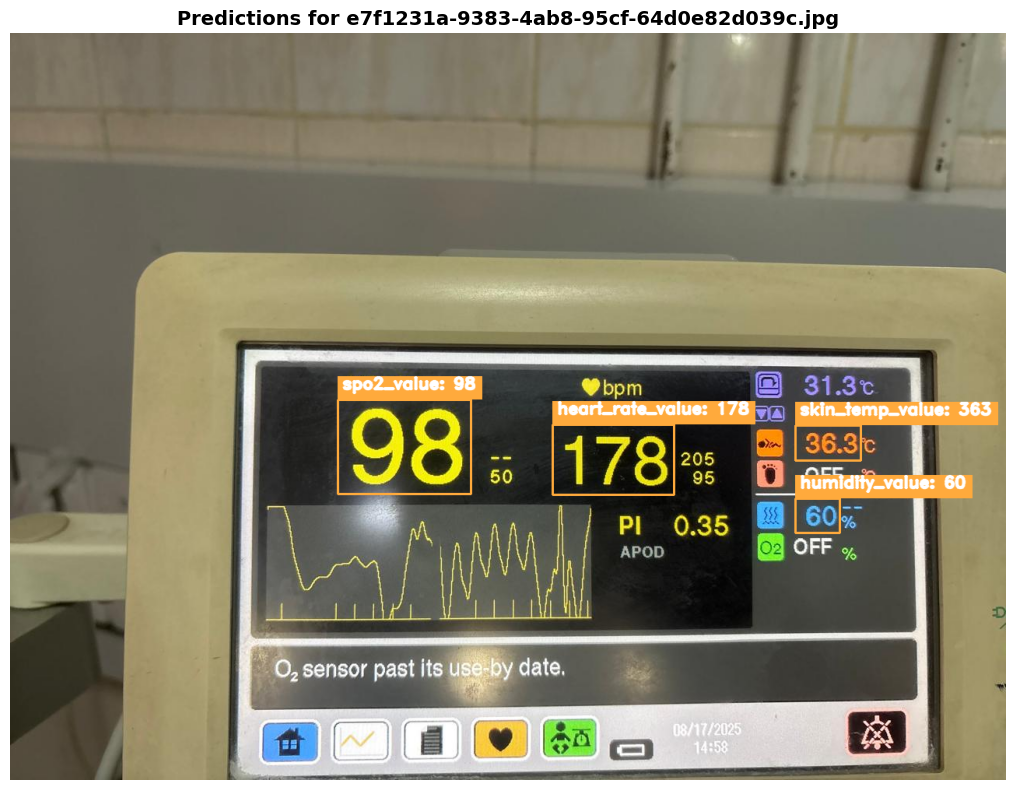


PREDICTION COMPARISON


,Parameter,Raw OCR,Corrected,Source,Status,Issues
0,Heart Rate,178,178,ocr_direct,valid,None
1,Humidity,60,60,ocr_direct,valid,None
2,Skin Temperature,363,36.3,ocr_corrected,valid,"Out of range: 363.0 not in [32.0, 39.0]; Appli..."
3,SpO2,98,98,ocr_direct,valid,None



SAMPLE 2/3


c:\Users\sahan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


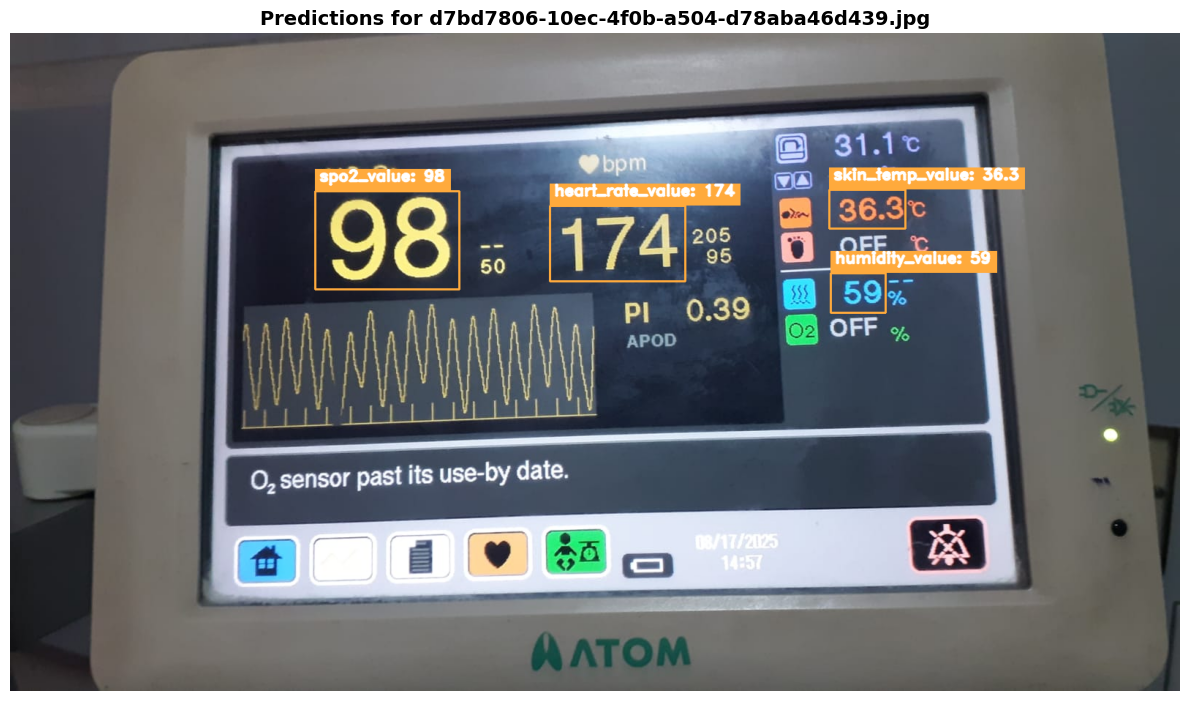


PREDICTION COMPARISON


,Parameter,Raw OCR,Corrected,Source,Status,Issues
0,Heart Rate,174,174,ocr_direct,valid,None
1,Humidity,59,59,ocr_direct,valid,None
2,Skin Temperature,36.3,36.3,ocr_direct,valid,None
3,SpO2,98,98,ocr_direct,valid,None



SAMPLE 3/3


c:\Users\sahan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


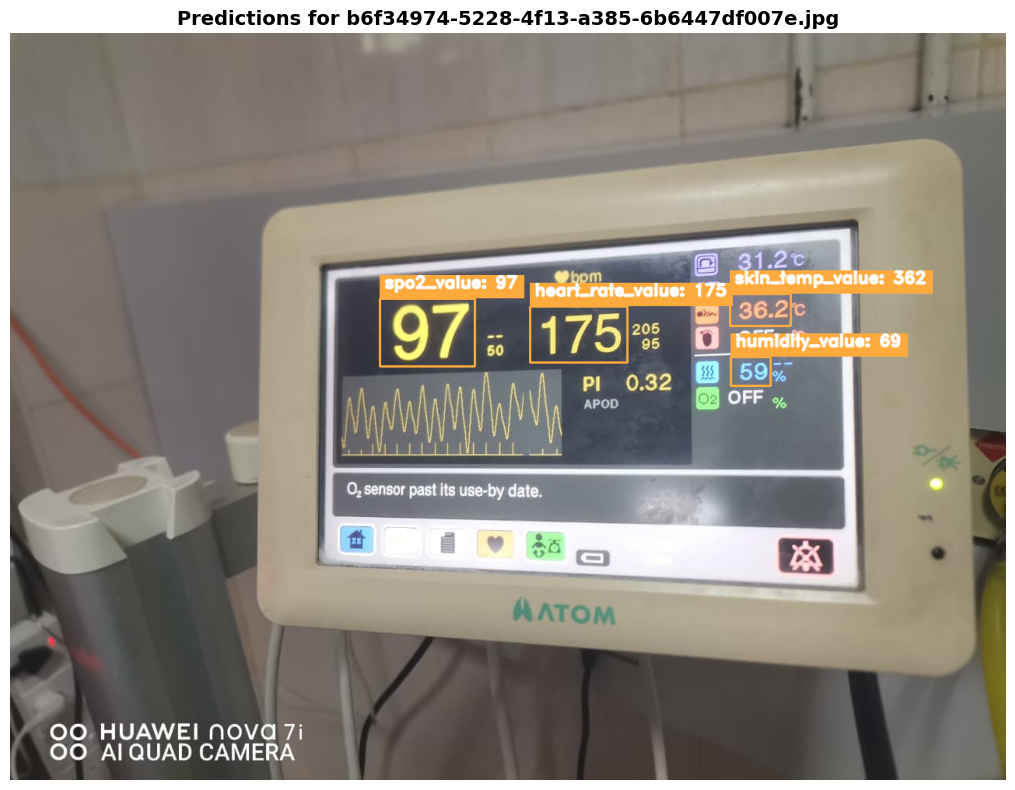


PREDICTION COMPARISON


,Parameter,Raw OCR,Corrected,Source,Status,Issues
0,Heart Rate,175,175,ocr_direct,valid,None
1,Humidity,69,69,ocr_direct,valid,None
2,Skin Temperature,362,36.2,ocr_corrected,valid,"Out of range: 362.0 not in [32.0, 39.0]; Appli..."
3,SpO2,97,97,ocr_direct,valid,None


In [35]:
def visualize_corrections(image_path, model):
    """
    Visualize OCR detections with raw and corrected values side-by-side.
    """
    # Get raw predictions with annotated image
    raw_pred, annotated = run_ocr_on_detection(image_path, model, return_debug=True)
    
    # Apply post-processing
    pp_result = apply_postprocessing(raw_pred, min_confidence=0.5)
    corrected_pred = pp_result['corrected_predictions']
    val_log = pp_result['validation_log']
    
    # Display image
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    ax.set_title(f"Predictions for {Path(image_path).name}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Create comparison table
    comparison_data = []
    for cls in NUMERIC_CLASSES:
        config = VALUE_RANGES[cls]
        row = {
            'Parameter': config['description'],
            'Raw OCR': raw_pred.get(cls, {}).get('value', 'N/A'),
            'Corrected': corrected_pred.get(cls, {}).get('value', 'N/A'),
            'Source': corrected_pred.get(cls, {}).get('source', 'N/A'),
            'Status': val_log.get(cls, {}).get('status', 'unknown')
        }
        
        # Add issues if any
        issues = val_log.get(cls, {}).get('issues')
        if issues:
            row['Issues'] = '; '.join(issues)
        else:
            row['Issues'] = 'None'
        
        comparison_data.append(row)
    
    comparison_table = pd.DataFrame(comparison_data)
    
    print("\n" + "=" * 100)
    print("PREDICTION COMPARISON")
    print("=" * 100)
    display(comparison_table)
    
    return raw_pred, corrected_pred, val_log

# Run visualization on sample images
if 'image_paths' in globals() and image_paths and 'detector' in globals():
    print("Running post-processing visualization on sample images...\n")
    
    # Select a few random samples
    sample_count = min(3, len(image_paths))
    sample_paths = random.sample(image_paths, sample_count)
    
    for idx, img_path in enumerate(sample_paths, 1):
        print(f"\n{'=' * 100}")
        print(f"SAMPLE {idx}/{sample_count}")
        print(f"{'=' * 100}")
        try:
            raw, corrected, log = visualize_corrections(img_path, detector)
        except Exception as e:
            print(f"Error processing {img_path.name}: {e}")
            continue
else:
    print("  Detector not loaded or no images available. Run the training and dataset cells first.")

### Visual Correction Demonstration

This cell provides **interactive visualization** of the post-processing corrections:

**Function:** `visualize_corrections()`

**Features:**

1. **Dual Processing**:

   - Runs raw OCR to get initial predictions
   - Applies post-processing validation and corrections
   - Generates annotated image with bounding boxes

2. **Visual Display**:

   - Shows annotated image with detected regions
   - Displays image filename in bold title
   - Color-coded bounding boxes for different parameters

3. **Comparison Table**:
   - Parameter name (human-readable description)
   - Raw OCR value (before correction)
   - Corrected value (after validation)
   - Source indicator (ocr_direct or ocr_corrected)
   - Validation status (valid, invalid, not_detected)
   - Issues list (corrections applied or problems found)

**Execution:**

- Randomly selects 3 sample images
- Processes each with full visualization
- Displays annotated image followed by detailed comparison table
- Shows how post-processing improves prediction quality

**Purpose:** Provides intuitive visual verification of the validation logic, making it easy to understand what corrections are applied and why.


### Export Corrected Predictions

This section exports the **post-processed predictions** with complete validation metadata to CSV format for:

- Further statistical analysis
- Model performance documentation
- Integration with downstream systems
- Quality assurance auditing

**Export Contents:**

- Raw OCR values
- Corrected values
- Validation status
- Confidence scores
- Applied corrections log


In [36]:
def export_corrected_predictions(image_paths, model, destination='artifacts/predictions_corrected.csv', sample_size=None, min_confidence=0.5):
    """
    Export post-processed OCR predictions with validation metadata to CSV.
    
    Args:
        image_paths: List of image paths to process
        model: YOLO detector model
        destination: Output CSV file path
        sample_size: Number of images to process (None = all)
        min_confidence: Minimum OCR confidence threshold
    """
    os.makedirs(os.path.dirname(destination), exist_ok=True)
    
    if sample_size:
        paths_to_process = random.sample(image_paths, min(sample_size, len(image_paths)))
    else:
        paths_to_process = image_paths
    
    rows = []
    
    print(f"Processing {len(paths_to_process)} images with post-processing...")
    
    for idx, img_path in enumerate(paths_to_process, 1):
        if idx % 10 == 0:
            print(f"  Processed {idx}/{len(paths_to_process)} images...")
        
        try:
            # Get raw predictions
            raw_pred = run_ocr_on_detection(img_path, model)
            
            # Apply post-processing
            pp_result = apply_postprocessing(
                raw_pred,
                min_confidence=min_confidence
            )
            
            corrected_pred = pp_result['corrected_predictions']
            val_log = pp_result['validation_log']
            
            # Create row for each detected class
            for class_name in NUMERIC_CLASSES:
                if class_name in raw_pred or class_name in corrected_pred:
                    row = {
                        'image': str(img_path),
                        'class': class_name,
                        'raw_value': raw_pred.get(class_name, {}).get('value'),
                        'corrected_value': corrected_pred.get(class_name, {}).get('value'),
                        'source': corrected_pred.get(class_name, {}).get('source', 'N/A'),
                        'det_conf': raw_pred.get(class_name, {}).get('det_conf'),
                        'ocr_conf': raw_pred.get(class_name, {}).get('ocr_conf'),
                        'validation_status': val_log.get(class_name, {}).get('status', 'unknown'),
                        'issues': '; '.join(val_log.get(class_name, {}).get('issues', [])) if val_log.get(class_name, {}).get('issues') else None
                    }
                    rows.append(row)
        
        except Exception as e:
            print(f"  Warning: Failed to process {img_path.name}: {e}")
            continue
    
    if rows:
        df = pd.DataFrame(rows)
        df.to_csv(destination, index=False)
        print(f"\n✓ Saved {len(df)} corrected predictions → {destination}")
        
        # Display summary statistics
        print("\n" + "=" * 80)
        print("EXPORT SUMMARY")
        print("=" * 80)
        print(f"Total predictions: {len(df)}")
        print(f"\nBy validation status:")
        print(df['validation_status'].value_counts().to_string())
        print(f"\nBy source:")
        print(df['source'].value_counts().to_string())
        
        # Show sample of exported data
        print("\n" + "=" * 80)
        print("SAMPLE OF EXPORTED DATA (first 10 rows)")
        print("=" * 80)
        display(df.head(10))
        
        return df
    else:
        print("No predictions to export.")
        return None

# Export corrected predictions on sample images
if 'image_paths' in globals() and image_paths and 'detector' in globals():
    print("Exporting corrected predictions...\n")
    corrected_df = export_corrected_predictions(
        image_paths,
        detector,
        sample_size=50,  # Adjust as needed
        min_confidence=0.5
    )
else:
    print("  Detector not loaded or no images available. Run the training and dataset cells first.")

Exporting corrected predictions...

Processing 50 images with post-processing...


c:\Users\sahan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Processed 10/50 images...
  Processed 20/50 images...
  Processed 20/50 images...
  Processed 30/50 images...
  Processed 30/50 images...
  Processed 40/50 images...
  Processed 40/50 images...
  Processed 50/50 images...
  Processed 50/50 images...

✓ Saved 200 corrected predictions → artifacts/predictions_corrected.csv

EXPORT SUMMARY
Total predictions: 200

By validation status:
validation_status
valid      169
invalid     31

By source:
source
ocr_direct       144
N/A               31
ocr_corrected     25

SAMPLE OF EXPORTED DATA (first 10 rows)

✓ Saved 200 corrected predictions → artifacts/predictions_corrected.csv

EXPORT SUMMARY
Total predictions: 200

By validation status:
validation_status
valid      169
invalid     31

By source:
source
ocr_direct       144
N/A               31
ocr_corrected     25

SAMPLE OF EXPORTED DATA (first 10 rows)


,image,class,raw_value,corrected_value,source,det_conf,ocr_conf,validation_status,issues
0,C:\Users\sahan\Desktop\MYProjects\Neonatal_inc...,heart_rate_value,174,174,ocr_direct,0.877825,0.999998,valid,None
1,C:\Users\sahan\Desktop\MYProjects\Neonatal_inc...,humidity_value,68,68,ocr_corrected,0.869102,0.463615,valid,Low OCR confidence: 0.46 < 0.5
2,C:\Users\sahan\Desktop\MYProjects\Neonatal_inc...,skin_temp_value,363,36.3,ocr_corrected,0.862630,0.883665,valid,"Out of range: 363.0 not in [32.0, 39.0]; Appli..."
3,C:\Users\sahan\Desktop\MYProjects\Neonatal_inc...,spo2_value,97,97,ocr_direct,0.922303,0.974356,valid,None
4,C:\Users\sahan\Desktop\MYProjects\Neonatal_inc...,heart_rate_value,152,152,ocr_direct,0.861786,0.996794,valid,None
5,C:\Users\sahan\Desktop\MYProjects\Neonatal_inc...,humidity_value,56,56,ocr_direct,0.892401,0.999413,valid,None
6,C:\Users\sahan\Desktop\MYProjects\Neonatal_inc...,skin_temp_value,37.6,37.6,ocr_direct,0.870248,0.845824,valid,None
7,C:\Users\sahan\Desktop\MYProjects\Neonatal_inc...,spo2_value,98,98,ocr_direct,0.895132,0.836381,valid,None
8,C:\Users\sahan\Desktop\MYProjects\Neonatal_inc...,heart_rate_value,173,173,ocr_direct,0.964171,0.697769,valid,None
9,C:\Users\sahan\Desktop\MYProjects\Neonatal_inc...,humidity_value,59,59,ocr_direct,0.870572,0.975497,valid,None


### Batch Export Corrected Predictions

This cell exports **validated predictions** to CSV format for analysis and documentation:

**Function:** `export_corrected_predictions()`

**Parameters:**

- `image_paths` - List of images to process
- `model` - Trained YOLO detector
- `destination` - Output CSV file path
- `sample_size` - Number of images to process (None = all)
- `min_confidence` - OCR confidence threshold (default: 0.5)

**Export Process:**

1. **Batch Processing**:

   - Processes specified number of images
   - Shows progress updates every 10 images
   - Handles errors gracefully with warnings

2. **Data Collection**:

   - Raw OCR values
   - Corrected values after validation
   - Source indicator (direct or corrected)
   - Detection confidence scores
   - OCR confidence scores
   - Validation status
   - List of issues/corrections applied

3. **CSV Structure**:
   Each row contains one parameter from one image with all metadata

**Export Summary:**

- Total predictions exported
- Validation status distribution
- Source type distribution (direct vs. corrected)
- Sample of exported data (first 10 rows)

**Use Cases:**

- Statistical analysis of prediction quality
- Documentation for quality assurance
- Integration with external analytics tools
- Batch processing of historical data

**Output:** CSV file saved to artifacts directory with comprehensive validation metadata.


### Production Integration Guidelines

The post-processing validation logic can be integrated into various production scenarios:

### Use Cases

1. **Single Image Analysis** - Use `apply_postprocessing()` with validation only (no temporal smoothing). Invalid values are rejected.

2. **Batch Processing** - Apply correction logic to historical image datasets to improve retrospective analysis accuracy.

3. **Live Video Streams** - Implement separate frame-to-frame smoothing logic that maintains previous valid values across consecutive frames. Requires state management.

4. **Alert Systems** - Configure automated alerts when validation status indicates persistent invalid patterns or out-of-range readings.

5. **Dashboard Display** - Show both raw and corrected values with confidence indicators and validation status for clinical transparency.

### Key Functions for Deployment

- `validate_and_correct_value()` - Validates and corrects individual readings
- `apply_postprocessing()` - Processes complete prediction dictionaries (single image mode)
- `VALUE_RANGES` - Medical range configuration (customize per clinical context)

### Important Implementation Note

This notebook implementation is designed for **single image analysis** without temporal dependencies. For **real-time video monitoring** in the Streamlit application, separate temporal smoothing logic with inter-frame state management must be implemented to maintain reading continuity across video frames.


## Structured Data Persistence

This section aggregates per-image vital sign readings into a **structured CSV format** suitable for:

- **Downstream analytics** and statistical analysis
- **Dashboard integration** for real-time monitoring
- **Data warehousing** for long-term clinical studies
- **Quality assurance** and audit trails

The exported data includes detection confidence, OCR confidence, and extracted values for each vital sign parameter.


In [ ]:
import os

def export_predictions(predictions, destination='artifacts/predictions.csv'):
    """Export OCR predictions to CSV."""
    # Ensure directory exists
    os.makedirs(os.path.dirname(destination), exist_ok=True)
    
    rows = []
    for img_path, preds in predictions.items():
        for class_name, data in preds.items():
            row = {'image': img_path, 'class': class_name, 'value': data['value'], 
                   'det_conf': data['det_conf'], 'ocr_conf': data['ocr_conf']}
            rows.append(row)
    df = pd.DataFrame(rows)
    df.to_csv(destination, index=False)
    print(f'✓ Saved {len(df)} records -> {destination}')
    return df

# Sample predictions on a few images
sample_size = 10
sample_images = image_paths[:sample_size]

# print(f"Running OCR predictions on {sample_size} sample images...")
# preds_dict = {str(p): run_ocr_on_detection(p, detector) for p in sample_images}
# export_predictions(preds_dict)
# print("✓ Predictions export completed successfully!")

Running OCR predictions on 10 sample images...
✓ Saved 40 records -> artifacts/predictions.csv
✓ Predictions export completed successfully!
✓ Saved 40 records -> artifacts/predictions.csv
✓ Predictions export completed successfully!


### Export Predictions to CSV

This cell defines a function to **export raw OCR predictions** in structured CSV format:

**Function:** `export_predictions()`

**Features:**

- Takes dictionary of image paths → predictions
- Flattens nested prediction structure into tabular format
- Creates one row per parameter per image
- Includes detection confidence and OCR confidence scores

**CSV Columns:**

- `image` - Image file path
- `class` - Parameter name (vital sign type)
- `value` - Extracted numeric value
- `det_conf` - YOLO detection confidence (0-1)
- `ocr_conf` - EasyOCR confidence (0-1)

**Example Usage:**
The commented code shows how to run predictions on sample images and export results. Uncomment when ready to execute batch export.

**Output:** Saves CSV file to artifacts directory and prints confirmation with record count.

**Note:** This exports raw predictions without post-processing validation. For validated exports, use the `export_corrected_predictions()` function instead.


## Model Export for Production

After successful training and validation, the trained model weights must be exported for **production deployment**.

**Process:**

1. Locate the best performing checkpoint (`best.pt`) from the training run
2. Copy weights to the `models/` directory with a standardized filename
3. Version the exported model for tracking and rollback capability

**Output Location:** `models/incubator_yolov8n.pt`

This exported model file can be loaded directly in the production Streamlit application for real-time inference.


In [37]:
def export_best_weights(run_dir=None, target_path=MODEL_DIR / 'incubator_yolov8n_v3.pt', source_path=None):
    """Locate a YOLO `best.pt` file and copy it into the models directory."""
    def collect_candidates(candidate):
        paths = []
        if candidate is None:
            return paths
        candidate = Path(candidate)
        if candidate.is_file():
            paths.append(candidate)
        elif candidate.is_dir():
            default_best = candidate / 'weights' / 'best.pt'
            if default_best.exists():
                paths.append(default_best)
            paths.extend(sorted(candidate.glob('**/best.pt')))
        return paths

    seen = set()
    ordered_candidates = []

    # First try source_path if provided
    for item in collect_candidates(source_path):
        if item.exists() and item not in seen:
            seen.add(item)
            ordered_candidates.append(item)

    # Then try run_dir if provided
    for item in collect_candidates(run_dir):
        if item.exists() and item not in seen:
            seen.add(item)
            ordered_candidates.append(item)

    # Search for weights in common locations
    search_paths = [
        PROJECT_DIR / 'incubator',
        PROJECT_DIR / 'notebooks' / 'incubator',
        PROJECT_DIR / 'runs' / 'detect',
    ]
    
    for search_path in search_paths:
        if search_path.exists():
            found = sorted(
                search_path.glob('**/best.pt'),
                key=lambda p: p.stat().st_mtime if p.exists() else 0,
                reverse=True
            )
            for item in found:
                if item.exists() and item not in seen:
                    seen.add(item)
                    ordered_candidates.append(item)

    if not ordered_candidates:
        print("No best.pt weights were found. Train the detector or supply `source_path` pointing to the weights file.")
        return None

    chosen = ordered_candidates[0]
    target_path = Path(target_path)
    target_path.parent.mkdir(parents=True, exist_ok=True)

    if target_path.exists() and target_path.resolve() == chosen.resolve():
        print(f"✓ Weights already available at {target_path.resolve()}.")
        return target_path

    shutil.copy2(chosen, target_path)
    print(f"✓ Exported weights from {chosen} -> {target_path.resolve()}")
    return target_path

# Export the trained weights to models directory
print("Searching for trained model weights...")
result = export_best_weights()
if result:
    print(f"Model ready for deployment at: {result}")

Searching for trained model weights...
✓ Exported weights from c:\Users\sahan\Desktop\MYProjects\Neonatal_incubator_displayReader\notebooks\incubator\yolov8n-incubator-v3\weights\best.pt -> C:\Users\sahan\Desktop\MYProjects\Neonatal_incubator_displayReader\models\incubator_yolov8n_v3.pt
Model ready for deployment at: c:\Users\sahan\Desktop\MYProjects\Neonatal_incubator_displayReader\models\incubator_yolov8n_v3.pt


### Export Trained Model Weights

This cell locates and exports the **best model checkpoint** for production use:

**Function:** `export_best_weights()`

**Search Strategy:**

1. Checks provided `source_path` if specified
2. Checks provided `run_dir` if specified
3. Searches common training output locations:
   - `PROJECT_DIR/incubator`
   - `PROJECT_DIR/notebooks/incubator`
   - `PROJECT_DIR/runs/detect`
4. Recursively searches for `best.pt` files
5. Sorts by modification time (most recent first)

**Export Process:**

- Identifies best performing checkpoint (`best.pt`)
- Copies to standardized location in models directory
- Adds version suffix to filename (e.g., `incubator_yolov8n_v3.pt`)
- Avoids duplicate copies if file already exists

**Parameters:**

- `run_dir` - Optional specific training run directory
- `target_path` - Destination path for exported weights
- `source_path` - Direct path to weights file if known

**Output:**

- Confirmation message showing source and destination paths
- Returns Path object to exported weights file
- Ready for loading in production Streamlit application

**Purpose:** Standardizes model deployment by consolidating trained weights in a predictable location with version tracking.


## Production Deployment Integration

The development pipeline hands off to the production **Streamlit web application** (`streamlit_app/app.py`) for real-time monitoring.

### Post-Processing Module

All validation and correction logic has been modularized into a reusable Python package:

**Module Location:** `incubator_pipeline/postprocessing.py`

### Module Capabilities

- Range validation against medical standards
- Automatic decimal point correction
- Integer enforcement for appropriate parameters
- Confidence-based filtering
- Temporal smoothing for video streams

### Integration Instructions

Complete implementation guidelines are provided in **POST_PROCESSING_GUIDE.md**.

### Configuration for Different Deployment Modes

**Single Image Mode:**

- Set `use_previous_on_invalid=False`
- Each image analyzed independently
- Invalid values rejected without replacement

**Live Video Mode:**

- Set `use_previous_on_invalid=True`
- Enables temporal smoothing across frames
- Maintains previous valid values during momentary detection failures
- Provides smoother real-time monitoring experience

The modular architecture allows the same validation logic to be deployed across both batch processing and real-time streaming scenarios.
